# Capstone project: Pedicting HDB Prices

#### Objectives/ Problem Statement
To predict the price of new HDB launch before the launch <br>
_**Input a set of features and output a price **_

#### why this problem?
A practical problem that most Singaporeans (including myself) face 

## Part3_ Modelling_Round1d 
- Using Resale data
- y variable is the variance (take away the mean) 
- X data from 2005 onwards
- train set: 2005 to 2014
- test set : 2014 to 2018


**[Iteration 1: ](#iter1)** [SLR](#1slr)  ||  [MLR by category](#1mlrcat) <br> 
X = resale data <br>
y = resale['var_resale_price'] <br>

**[Iteration 2: ](#iter2)** [SLR](#2slr)  ||  [MLR by category](#2mlrcat) <br>
X = resale data <br>
y = resale['var_adj_price'] <br>


**[Iteration 3](#iter3)** <br>
X = resale data without time data<br>
y = resale['var_resale_price'] <br>
**[Iter3a - no yr:       ](#iter3a)**[MLR all](#3amlrall) || [ridge,lasso,enet](#3aregularization) <br>
**[Iter3b - no yr&month: ](#iter3b)**:[MLR all](#3bmlrall) || [ridge,lasso,enet](#3bregularization)

**[Iteration 4](#iter4)** <br>
X = resale data without time data<br>
y = resale['var_adj_price'] <br>
**[Iter4a - no yr:       ](#iter4a)**[MLR all](#4amlrall) || [ridge,lasso,enet](#4aregularization) <br>
**[Iter4b - no yr&month: ](#iter4b)**:[MLR all](#4bmlrall) || [ridge,lasso,enet](#4bregularization)

In [55]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Quick Cleaning 
(code and analysis taken from Part2_EDA)

In [2]:
resale = pd.read_csv('./datasets/resale_all.csv')
resale.drop([u'Unnamed: 0',u'geo_data',u'full_address','new full_address'],axis = 1,inplace=True)

#time
resale['date'] = pd.to_datetime(resale['month'])
resale['year'] = resale['date'].apply(lambda x:x.year)
resale['month'] = resale['date'].apply(lambda x:x.month)

#lease
resale['lease_commence_date'] = resale['lease_commence_date'].astype(int)
resale['calculated_remaining_lease'] = 99 - (resale['year'] - resale['lease_commence_date'])
resale['calculated_remaining_lease'] = [99 if yr >99 else yr for yr in resale['calculated_remaining_lease']]

#block 
resale['block_num'] = [re.findall('\d+',str(block_num))[0] for block_num in resale['block']]
resale['block_num'] = resale['block_num'].astype('int')

# flat model 
resale['flat_model'] = [model.upper() for model in resale['flat_model']]
resale['flat_model_PREMIUM'] = [1 if 'PREMIUM' in model else 0 for model in resale['flat_model']]
resale['flat_model_IMPROVED'] = [1 if 'IMPROVED' in model else 0 for model in resale['flat_model']]
resale['flat_model_MODEL_A'] = [1 if 'MODEL A' in model else 0 for model in resale['flat_model']]
resale.replace({'flat_model':{'MODEL A2':'OTHERS',
                              'PREMIUM APARTMENT':'APARTMENT',
                              'PREMIUM APARTMENT.':'APARTMENT',
                              'PREMIUM APARTMENT LOFT':'APARTMENT',
                              'MULTI GENERATION':'OTHERS',
                              '2-ROOM':'OTHERS',
                              'IMPROVED-MAISONETTE':'MAISONETTE',
                              'PREMIUM MAISONETTE':'MAISONETTE',
                              'IMPROVED-MAISONETTE':'MAISONETTE',
                              'MODEL A-MAISONETTE':'MAISONETTE',
                              'MODEL A':'OTHERS',
                              'IMPROVED':'OTHERS',
                              'TYPE S1': 'TYPE S',
                              'TYPE S2': 'TYPE S'
                              }},inplace=True)

#flat type
resale.replace({'flat_type':{'MULTI-GENERATION':'MULTI GENERATION'}},inplace=True)

#storey
resale['storey'] = [7 if floor == '06 TO 10' else 
                        13 if floor == '11 TO 15' else 
                        16 if floor == '19 TO 21' else
                        20 if floor[0] =='2' else 
                        30 if int(floor[0]) >= 3 else 
                        int(floor[:2]) for floor in resale['storey_range']]

resale.head()

C:\Users\ngyen\Anaconda2python2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,...,formatted_address,postal_code,date,year,calculated_remaining_lease,block_num,flat_model_PREMIUM,flat_model_IMPROVED,flat_model_MODEL_A,storey
0,309,OTHERS,1 ROOM,31.0,1977,1,NaN,9000.0,10 TO 12,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,10
1,309,OTHERS,1 ROOM,31.0,1977,1,NaN,6000.0,04 TO 06,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,4
2,309,OTHERS,1 ROOM,31.0,1977,1,NaN,8000.0,10 TO 12,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,10
3,309,OTHERS,1 ROOM,31.0,1977,1,NaN,6000.0,07 TO 09,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,7
4,309,OTHERS,1 ROOM,31.0,1977,2,NaN,8000.0,04 TO 06,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-02-01,1990,86,309,0,1,0,4


In [3]:
# Setting columns as string for sucessful pd.get_dummies 
resale['month_str'] = ['0'+str(x) if x <10 else str(x) for x in resale['month']]
resale['storey'] = resale['storey'].astype(str)
resale['year_str'] = resale['year'].astype(str)
dummy_col = ['flat_type','storey','year_str','month_str','town']

In [4]:
#Taking into consideration inflation across the years, we adjust the resale_price accordingly 
# inflation_rate is obtained from MAS website

inflation = pd.read_csv('./datasets/inflation_rate.csv')
inflation['value_of_1000_today'] = inflation['value_of_1000_today'].astype(int)/1000
inflate = inflation[['Year','value_of_1000_today']].values.tolist()

resale['adj_price'] = [price*change for p_year,price in zip(resale['year'],resale['resale_price']) 
                                        for [year,change] in inflate 
                                        if p_year == year]

In [5]:
price_time = resale.groupby(['date']).mean()[['resale_price','adj_price']].reset_index()
price_time.columns = ['date','mean_resale_price','mean_adj_price']
print price_time.shape
price_time.head()

(341, 3)


,date,mean_resale_price,mean_adj_price
0,1990-01-01,64911.755424,109765.778422
1,1990-02-01,67657.745726,114409.248024
2,1990-03-01,66513.820624,112474.870675
3,1990-04-01,65649.574669,111013.430766
4,1990-05-01,67621.865140,114348.573952


In [6]:
resale = resale.merge(price_time,on='date')

In [7]:
resale['var_resale_price'] = resale['resale_price'] - resale['mean_resale_price']
resale['var_adj_price'] = resale['adj_price'] - resale['mean_adj_price']

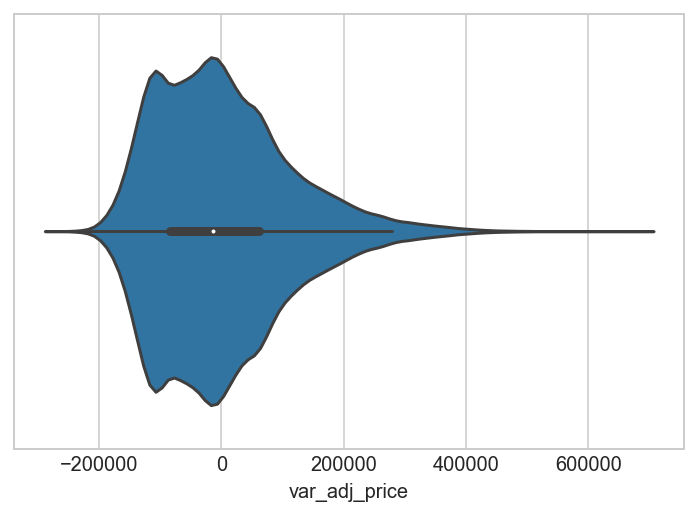

In [8]:
sns.violinplot(resale[(resale['year']<2014)&(resale['year']>2004)]['var_adj_price'])

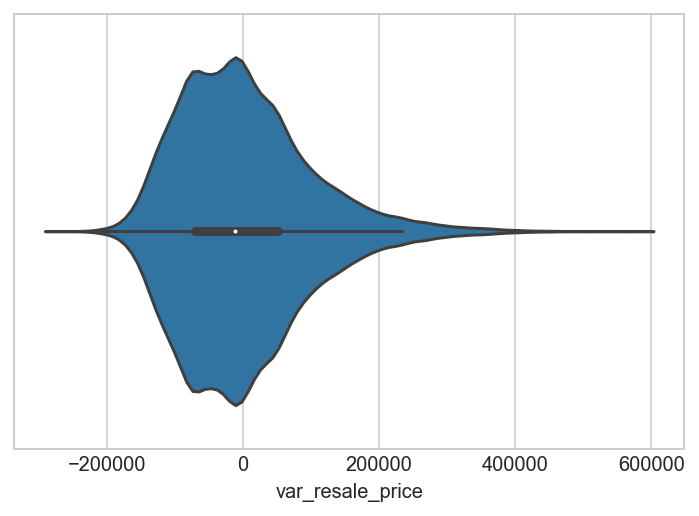

In [9]:
sns.violinplot(resale[(resale['year']<2014)&(resale['year']>2004)]['var_resale_price'])

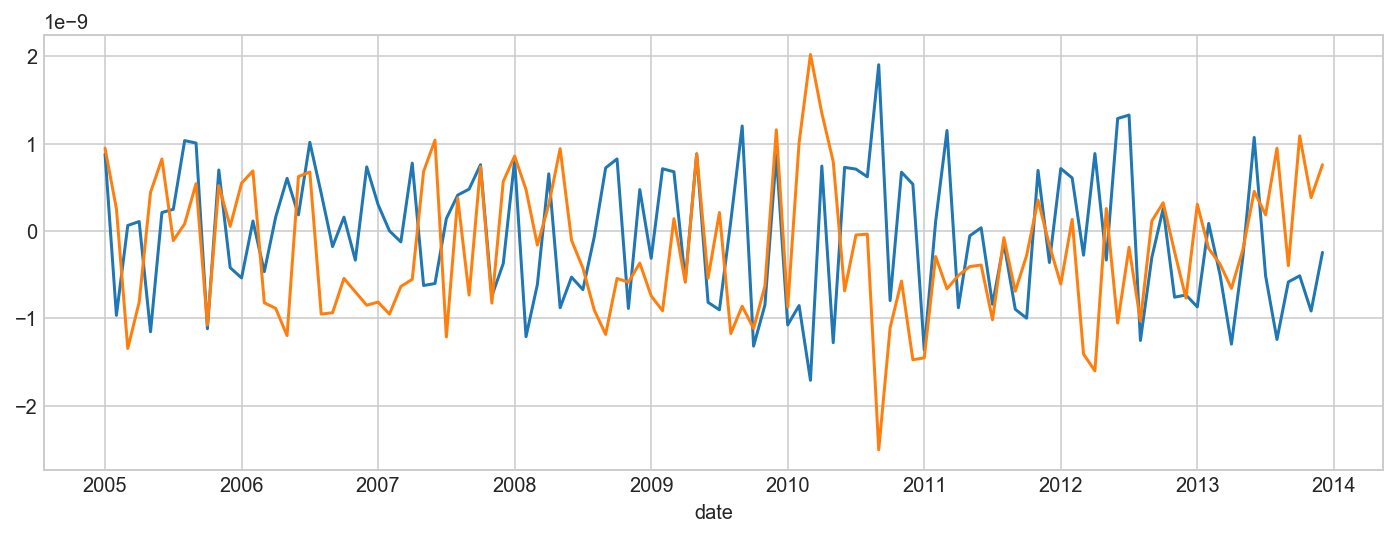

In [10]:
plt.figure(figsize = (12,4))
resale[(resale['year']<2014)&(resale['year']>2004)].groupby('date').mean()['var_resale_price'].plot()
resale[(resale['year']<2014)&(resale['year']>2004)].groupby('date').mean()['var_adj_price'].plot()

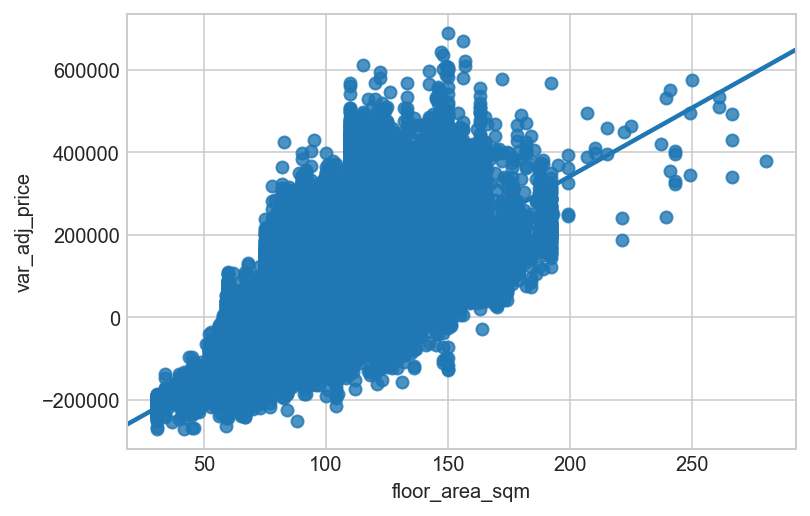

In [11]:
graph_df1 = resale[(resale['year']<=2014)&(resale['year']>2004)]
sns.regplot('floor_area_sqm','var_adj_price',graph_df1)

In [12]:
# From Part2_EDA, some of the flat models have been subsumed into 'flat_model_OTHERS' 
# Instead of dropping the first variable, we will drop 'falt_model_Others instead
df1 = resale[['flat_model_PREMIUM', 'flat_model_IMPROVED', 'flat_model_MODEL_A']]
df2 = pd.get_dummies(resale[['flat_model']]).drop('flat_model_OTHERS',axis = 1)
df3 = pd.get_dummies(resale[dummy_col],drop_first=True)
df4 = resale[['latitude', 'longitude']]
df5 = resale[['calculated_remaining_lease','floor_area_sqm','lease_commence_date']]

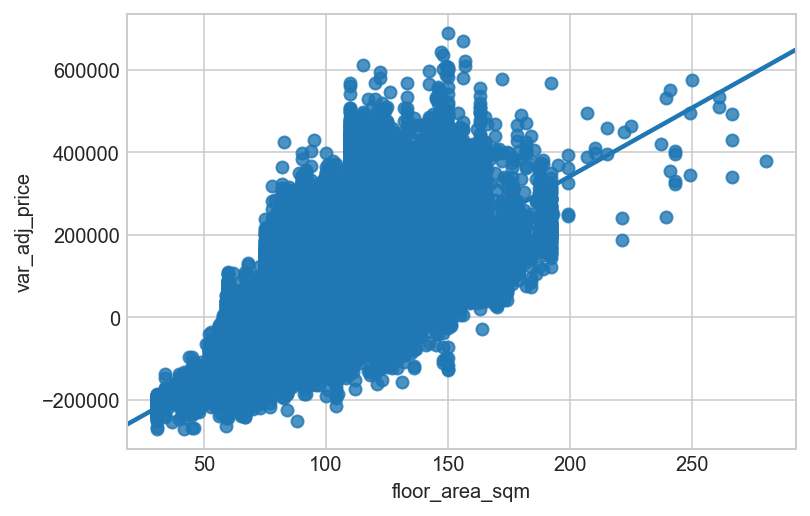

In [13]:
df = pd.concat([df1,df2,df3,df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)
graph_df2 = df[(df['year']<=2014)&(df['year']>2004)]
sns.regplot('floor_area_sqm','var_adj_price',graph_df2)

In [14]:
all(graph_df1['floor_area_sqm'] == graph_df2['floor_area_sqm'])

True

# Modelling 

### Standard Regression
**[Iteration 1: ](#iter1)** [SLR](#1slr)  ||  [MLR by category](#1mlrcat) <br> 
X = resale data <br>
y = resale['var_resale_price'] <br>

**[Iteration 2: ](#iter2)** [SLR](#2slr)  ||  [MLR by category](#2mlrcat) <br>
X = resale data <br>
y = resale['var_adj_price'] <br>


**[Iteration 3](#iter3)** <br>
X = resale data without time data<br>
y = resale['var_resale_price'] <br>
**[Iter3a - no yr:       ](#iter3a)**[MLR all](#3amlrall) || [ridge,lasso,enet](#3aregularization) <br>
**[Iter3b - no yr&month: ](#iter3b)**:[MLR all](#3bmlrall) || [ridge,lasso,enet](#3bregularization)

**[Iteration 4](#iter4)** <br>
X = resale data without time data<br>
y = resale['var_adj_price'] <br>
**[Iter4a - no yr:       ](#iter4a)**[MLR all](#4amlrall) || [ridge,lasso,enet](#4aregularization) <br>
**[Iter4b - no yr&month: ](#iter4b)**:[MLR all](#4bmlrall) || [ridge,lasso,enet](#4bregularization)

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [16]:
def Obtain_summary(estimator,X_train, y_train, X_test, y_test):
    scores = cross_val_score(estimator, X_train, y_train, cv=10)
    score_test = estimator.score(X_test,y_test)
    print 'Mean of scores: {} | Std of scores: {}'.format(np.mean(scores), np.std(scores))
    print 'Test score: {}'.format(score_test)
    
    return {'mean_score':np.mean(scores), 
            'std_score':np.std(scores), 
            'scores':scores,
            'for_compare': [np.mean(scores),np.std(scores), score_test]
           }

def Obtain_coefficients(estimator,X_train,y_train,X):
    coefficient = pd.DataFrame({'variable':X.columns,
                                'coef':estimator.coef_,
                                'abs_coef':np.abs(estimator.coef_)})
    feat_coeff = coefficient[coefficient['abs_coef']>0]
    print '{} out of {} features are selected.' .format(feat_coeff.shape[0],len(X.columns))
    return coefficient
    

def Add_model(model_name,summary,df):
    row = pd.DataFrame([model_name]+summary['for_compare'],
                       index=['model','train_mean_score','train_std_score','test_score']).T
    
    if type(df) == list:
        df = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
        new_df = pd.concat([df,row])
    else:
        new_df = pd.concat([df,row])
        
    return new_df

In [17]:
def Analyse_coef(coefficient,df):
    print 'Coefficients not used: {}'.format([col for col in df.columns 
                                              if col not in list(coefficient[coefficient['abs_coef'] != 0].variable)])
    
    print coefficient.sort_values('abs_coef',ascending = False).head(10)
    
    ##################First Row of Graphs##################
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,3))
    #STOREY_RANGE Graph [0][0]
    storey_col = [col for col in X.columns if 'storey' in col] 
    df_storey_col = pd.DataFrame(coefficient.set_index('variable')['coef'].T[storey_col].sort_values(ascending=False))

    sns.barplot(y=df_storey_col.index,x = df_storey_col.coef,orient='h',ax=ax[0])
    ax[0].set_ylabel('Storey Range')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Storey Range')

    #FLAT_TYPE Graph [0][1]
    flat_type_col = [col for col in X.columns if 'flat_type' in col] 
    df_flat_type = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_type_col ].sort_values(ascending =False))
    sns.barplot(y=df_flat_type.index,x = df_flat_type.coef,orient='h',ax=ax[1])
    ax[1].set_yticklabels([col[10:] for col in df_flat_type.index])
    ax[1].set_ylabel('Flat Type')
    ax[1].set_xlabel('Coefficients')
    ax[1].set_title('Analysis of Coefficients for Flat Type');

    ##################Second Row of Graphs##################
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,4))
    #FLAT_MODEL Graph [1][0]
    flat_model_col = [col for col in X.columns if 'flat_model' in col] 
    df_flat_model = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_model_col].sort_values(ascending = False))
    sns.barplot(y=df_flat_model.index,x = df_flat_model.coef,orient='h',ax=ax[0])
    ax[0].set_yticklabels([col[11:] for col in df_flat_model.index])
    ax[0].set_ylabel('Flat Model')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Flat Model');

    #Month Graph [1][1]
    try: 
        flat_month = [col for col in X.columns if 'month' in col] 
        df_month = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_month])
        sns.barplot(y=df_month.index,x = df_month.coef,orient='h',ax=ax[1])
        ax[1].set_yticklabels([col[:6]+col[-2:] for col in df_month.index])
        ax[1].set_ylabel('Flat Model')
        ax[1].set_xlabel('Coefficients')
        ax[1].set_title('Analysis of Coefficients for Flat Model');
    except:
        pass

    ##################ThirdRow of Graphs################## 
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,6))
    #TOWN ax[0]
    flat_town = [col for col in X.columns if 'town' in col] 
    df_town = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_town].sort_values(ascending=False))
    sns.barplot(y=df_town.index,x = df_town.coef,orient='h',ax=ax[0])
    ax[0].set_yticklabels([col[5:] for col in df_town.index])
    ax[0].set_ylabel('Flat Model')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Flat Model');

    #YEAR ax[1]
    try:
        flat_year = [col for col in X.columns if 'year' in col] 
        df_year = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_year])
        sns.barplot(y=df_year.index,x = df_year.coef,orient='h',ax=ax[1])
        ax[1].set_yticklabels([col[5:] for col in df_year.index])
        ax[1].set_ylabel('Flat Model')
        ax[1].set_xlabel('Coefficients')
        ax[1].set_title('Analysis of Coefficients for Flat Model')
    except:
        pass

<a id='iter1'></a>
## Iteration 1
| **X** | **y**|
|------|------|
| dummy: ['flat_model','flat_type', 'storey', 'year', 'month_str', 'town']] <br> cont.: ['latitude', 'longitude',calculated remaining lease]  | resale['resale_price']|

<a id='1slr'></a>
#### Iteration1: Single Variable Linear Regression
want to see the effect of each single variable on resale_price

In [18]:
df = pd.concat([df1,df2,df3,df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)
train = df[(df['year']<2014)&(df['year']>2004)]
test = df[df['year']>=2014]

In [19]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for col in train.drop(['var_resale_price','var_adj_price','year'],axis=1).columns:
    X_train = train[[col]]
    y_train = train['var_resale_price']
    X_test = test[[col]]
    y_test = test['var_resale_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '--------------------------------------'

flat_model_PREMIUM
Mean of scores: 0.0156023980875 | Std of scores: 0.00177891459438
Test score: -0.000511122539532
--------------------------------------
flat_model_IMPROVED
Mean of scores: 0.010802841646 | Std of scores: 0.00249583610441
Test score: 0.00140684533032
--------------------------------------
flat_model_MODEL_A
Mean of scores: 0.000305487218074 | Std of scores: 0.00130691247773
Test score: 0.00175964373512
--------------------------------------
flat_model_ADJOINED FLAT
Mean of scores: 0.004408805636 | Std of scores: 0.00180806830717
Test score: 0.00411876962517
--------------------------------------
flat_model_APARTMENT
Mean of scores: 0.086639354043 | Std of scores: 0.0117815719583
Test score: 0.030148135911
--------------------------------------
flat_model_DBSS
Mean of scores: -6.86655692521e-05 | Std of scores: 7.90060741552e-05
Test score: 0.0
--------------------------------------
flat_model_MAISONETTE
Mean of scores: 0.0754074216192 | Std of scores: 0.00545607593591

Mean of scores: -8.31771543433e-05 | Std of scores: 9.18968258766e-05
Test score: 0.0
--------------------------------------
month_str_07
Mean of scores: -0.000205620579594 | Std of scores: 0.000301799833321
Test score: 0.0
--------------------------------------
month_str_08
Mean of scores: -0.000355651595776 | Std of scores: 0.000547494229029
Test score: 0.0
--------------------------------------
month_str_09
Mean of scores: -6.99600825047e-05 | Std of scores: 8.04758201442e-05
Test score: 0.0
--------------------------------------
month_str_10
Mean of scores: -6.99592833978e-05 | Std of scores: 8.04992592862e-05
Test score: 0.0
--------------------------------------
month_str_11
Mean of scores: -0.000269737575845 | Std of scores: 0.00041817870392
Test score: 0.0
--------------------------------------
month_str_12
Mean of scores: -7.85753497379e-05 | Std of scores: 8.69677424405e-05
Test score: 0.0
--------------------------------------
town_BEDOK
Mean of scores: 0.00435516754318 | St

In [20]:
summary_SLR.sort_values('train_mean_score',ascending=False).head(20)

,model,train_mean_score,train_std_score,test_score
0,floor_area_sqm,0.573302,0.0418955,0.406669
0,flat_type_3 ROOM,0.340271,0.0163436,0.240624
0,lease_commence_date,0.197003,0.019617,0.122907
0,calculated_remaining_lease,0.189338,0.0168864,0.108212
0,flat_type_EXECUTIVE,0.186145,0.0143113,0.140777
0,flat_type_5 ROOM,0.183326,0.0230802,0.11553
0,flat_model_NEW GENERATION,0.0990079,0.00493103,0.072318
0,flat_model_APARTMENT,0.0866394,0.0117816,0.0301481
0,flat_model_MAISONETTE,0.0754074,0.00545608,0.0764428
0,storey_20,0.0437322,0.00644777,0.0498434


In [21]:
summary_SLR.sort_values('train_mean_score',ascending=True).head(20)

,model,train_mean_score,train_std_score,test_score
0,town_QUEENSTOWN,-0.000462344,0.00146109,0.00178998
0,year_str_2007,-0.000365219,0.000591629,0
0,month_str_08,-0.000355652,0.000547494,0
0,year_str_2011,-0.000330328,0.000370384,0
0,year_str_2009,-0.000330026,0.000372547,0
0,year_str_2005,-0.000326153,0.000594509,0
0,month_str_11,-0.000269738,0.000418179,0
0,month_str_07,-0.000205621,0.0003018,0
0,month_str_04,-0.00014338,0.00019804,0
0,month_str_06,-8.31772e-05,9.18968e-05,0


**Insights** <br>
From the summary scores, the factors that are quite important to var_resale_price are: 
- <br>

The factors that are not important are:
- 

<a id='1mlrcat'></a>
#### Iteration 1: Multiple Variable Linear Regression by Category

In [22]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for cat in ['flat_type','storey','year','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in train.columns if cat in col]
    X_train = train[cat_pred]
    y_train = train['var_resale_price']
    X_test = test[cat_pred]
    y_test = test['var_resale_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: 0.580726803155 | Std of scores: 0.0369571497938
Test score: 0.413500739984
--------------------------------
storey
Mean of scores: 0.114862182004 | Std of scores: 0.0164662709975
Test score: 0.144350881241
--------------------------------
year
Mean of scores: -0.00111675897388 | Std of scores: 0.00103306040017
Test score: -9.82147592114e+19
--------------------------------
month_str
Mean of scores: -0.000995772672239 | Std of scores: 0.000970541113911
Test score: 0.0
--------------------------------
town
Mean of scores: 0.110346052524 | Std of scores: 0.0210579088301
Test score: 0.0870537826691
--------------------------------
flat_model
Mean of scores: 0.313024172704 | Std of scores: 0.0145469772165
Test score: 0.238872126638
--------------------------------


In [23]:
summary_MLR.sort_values('train_mean_score',ascending=False)

,model,train_mean_score,train_std_score,test_score
0,flat_type,0.580727,0.0369571,0.413501
0,flat_model,0.313024,0.014547,0.238872
0,storey,0.114862,0.0164663,0.144351
0,town,0.110346,0.0210579,0.0870538
0,month_str,-0.000995773,0.000970541,0
0,year,-0.00111676,0.00103306,-9.82148e+19


**Insights** <br>
From the summary scores, the dummy factors that are quite important to resale_price are:
- year 
- flat_type
- flat_model

The factors that are not important are:
- month and surprisingly,
- storey

This is in sync with the SLR results above. 

<a id='iter2'></a>
## Iteration 2
| **X** | **y**|
|------|------|
| dummy: ['flat_model','flat_type', 'storey', 'year', 'month_str', 'town']] <br> cont.: ['latitude', 'longitude',calculated remaining lease]  | resale['adj_price']|

<a id='2slr'></a>
#### Iteration2: Single Variable Linear Regression
Want to see the effect of each single variable on resale_price

In [24]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for col in train.drop(['var_resale_price','var_adj_price','year'],axis=1).columns:
    X_train = train[[col]]
    y_train = train['var_adj_price']
    X_test = test[[col]]
    y_test = test['var_adj_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '-----------------------------'

flat_model_PREMIUM
Mean of scores: 0.0158097366593 | Std of scores: 0.00199105273591
Test score: -0.0025865791679
-----------------------------
flat_model_IMPROVED
Mean of scores: 0.0110613084294 | Std of scores: 0.00261217260706
Test score: 0.000478922546305
-----------------------------
flat_model_MODEL_A
Mean of scores: 0.000402434910107 | Std of scores: 0.00110792804948
Test score: 0.0019819378822
-----------------------------
flat_model_ADJOINED FLAT
Mean of scores: 0.00473630429453 | Std of scores: 0.00137325054238
Test score: 0.00448626316779
-----------------------------
flat_model_APARTMENT
Mean of scores: 0.0875677648083 | Std of scores: 0.0110147183721
Test score: 0.0252170672278
-----------------------------
flat_model_DBSS
Mean of scores: -7.069043732e-05 | Std of scores: 7.95081300733e-05
Test score: 1.11022302463e-16
-----------------------------
flat_model_MAISONETTE
Mean of scores: 0.0773334885661 | Std of scores: 0.00605522486836
Test score: 0.0819643488328
----------

Mean of scores: -0.000203534389178 | Std of scores: 0.000283791295261
Test score: 1.11022302463e-16
-----------------------------
month_str_08
Mean of scores: -0.000380825383237 | Std of scores: 0.000592520404539
Test score: 3.33066907388e-16
-----------------------------
month_str_09
Mean of scores: -7.20175819096e-05 | Std of scores: 8.098119517e-05
Test score: 0.0
-----------------------------
month_str_10
Mean of scores: -7.20417902814e-05 | Std of scores: 8.11034941059e-05
Test score: 1.11022302463e-16
-----------------------------
month_str_11
Mean of scores: -0.000278250559445 | Std of scores: 0.000449148161948
Test score: 1.11022302463e-16
-----------------------------
month_str_12
Mean of scores: -8.10990073127e-05 | Std of scores: 8.60696544744e-05
Test score: 1.11022302463e-16
-----------------------------
town_BEDOK
Mean of scores: 0.00453606340147 | Std of scores: 0.00110840212814
Test score: 0.00242425176068
-----------------------------
town_BISHAN
Mean of scores: 0.0205

In [25]:
summary_SLR.sort_values('train_mean_score',ascending=False).head(20)

,model,train_mean_score,train_std_score,test_score
0,floor_area_sqm,0.590116,0.0517499,0.424344
0,flat_type_3 ROOM,0.351475,0.0257874,0.248978
0,lease_commence_date,0.2008,0.02155,0.117155
0,calculated_remaining_lease,0.192805,0.0187383,0.0987013
0,flat_type_EXECUTIVE,0.189781,0.0152924,0.146873
0,flat_type_5 ROOM,0.187079,0.0221309,0.117646
0,flat_model_NEW GENERATION,0.102322,0.0068861,0.0753936
0,flat_model_APARTMENT,0.0875678,0.0110147,0.0252171
0,flat_model_MAISONETTE,0.0773335,0.00605522,0.0819643
0,storey_20,0.0450246,0.00568684,0.0523235


In [26]:
summary_SLR.sort_values('train_mean_score',ascending=True).head(20)

,model,train_mean_score,train_std_score,test_score
0,year_str_2007,-0.000384521,0.000611923,1.11022e-16
0,month_str_08,-0.000380825,0.00059252,3.33067e-16
0,year_str_2005,-0.000379894,0.000645147,1.11022e-16
0,town_QUEENSTOWN,-0.000358499,0.000913409,0.00140353
0,year_str_2011,-0.000329133,0.000395055,1.11022e-16
0,year_str_2009,-0.000326316,0.000362976,1.11022e-16
0,month_str_11,-0.000278251,0.000449148,1.11022e-16
0,month_str_07,-0.000203534,0.000283791,1.11022e-16
0,month_str_04,-0.000136659,0.000176076,1.11022e-16
0,year_str_2006,-8.3442e-05,8.50268e-05,1.11022e-16


**Insights** <br>
From the summary scores, the factors that are quite important to adj_price are:
- floor_area_sqm
- 3 room, 5 room, executive etc --> flat_type
- lease_commence_date
- new generation, apartments, premium etc --> flat_model (a few factors only)
- Certain years
- Calculated_remaining_lease
- Storey height

The factors that are not important are:
- month
- certain towns
- certain years

Effect on adj_price is higher than effect on resale_price

<a id='2mlrcat'></a>
#### Iteration 2: Multiple Variable Linear Regression by Category

In [27]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for cat in ['flat_type','storey','year','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in train.columns if cat in col]
    X_train = train[cat_pred]
    y_train = train['var_adj_price']
    X_test = test[cat_pred]
    y_test = test['var_adj_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: 0.596175443467 | Std of scores: 0.0464128075005
Test score: 0.429189218171
--------------------------------
storey
Mean of scores: 0.117671991623 | Std of scores: 0.0130852956095
Test score: 0.149575748664
--------------------------------
year
Mean of scores: -0.00119065046284 | Std of scores: 0.00111123035799
Test score: -1.99229222447e+20
--------------------------------
month_str
Mean of scores: -0.00101190468541 | Std of scores: 0.000995510263246
Test score: 3.33066907388e-16
--------------------------------
town
Mean of scores: 0.1152184433 | Std of scores: 0.0141437153338
Test score: 0.0887773394304
--------------------------------
flat_model
Mean of scores: 0.321692938531 | Std of scores: 0.019785946828
Test score: 0.249772855592
--------------------------------


In [28]:
summary_MLR.sort_values('train_mean_score',ascending = False)

,model,train_mean_score,train_std_score,test_score
0,flat_type,0.596175,0.0464128,0.429189
0,flat_model,0.321693,0.0197859,0.249773
0,storey,0.117672,0.0130853,0.149576
0,town,0.115218,0.0141437,0.0887773
0,month_str,-0.0010119,0.00099551,3.33067e-16
0,year,-0.00119065,0.00111123,-1.99229e+20


<a id='iter3a'></a>
### Iteration 3a

In [29]:
df = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col]],df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)
train = df[(df['year']<2014)&(df['year']>2004)]
test = df[df['year']>=2014]
X = df.drop(['var_resale_price','var_adj_price','year'],axis=1)
X_train = train.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_train = train['var_resale_price']
X_test = test.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_test = test['var_resale_price']


In [30]:
X_train.columns

Index([u'flat_model_PREMIUM', u'flat_model_IMPROVED', u'flat_model_MODEL_A',
       u'flat_model_ADJOINED FLAT', u'flat_model_APARTMENT',
       u'flat_model_DBSS', u'flat_model_MAISONETTE',
       u'flat_model_NEW GENERATION', u'flat_model_SIMPLIFIED',
       u'flat_model_STANDARD', u'flat_model_TERRACE', u'flat_model_TYPE S',
       u'flat_type_2 ROOM', u'flat_type_3 ROOM', u'flat_type_4 ROOM',
       u'flat_type_5 ROOM', u'flat_type_EXECUTIVE',
       u'flat_type_MULTI GENERATION', u'storey_10', u'storey_13', u'storey_16',
       u'storey_20', u'storey_30', u'storey_4', u'storey_7', u'month_str_02',
       u'month_str_03', u'month_str_04', u'month_str_05', u'month_str_06',
       u'month_str_07', u'month_str_08', u'month_str_09', u'month_str_10',
       u'month_str_11', u'month_str_12', u'town_BEDOK', u'town_BISHAN',
       u'town_BUKIT BATOK', u'town_BUKIT MERAH', u'town_BUKIT PANJANG',
       u'town_BUKIT TIMAH', u'town_CENTRAL AREA', u'town_CHOA CHU KANG',
       u'town_CLEMENTI'

<a id='3amlrall'></a>
#### Iteration 3a: Multiple variable Linear regression: ALL 

In [31]:
ss=StandardScaler()

Mean of scores: 0.824597676283 | Std of scores: 0.0318835577863
Test score: -1.82902919008e+20
67 out of 67 features are selected.
Coefficients not used: []
        abs_coef          coef             variable
5   1.860289e+16  1.860289e+16      flat_model_DBSS
11  1.114019e+16  1.114019e+16    flat_model_TYPE S
50  1.106927e+15 -1.106927e+15    town_LIM CHU KANG
15  6.750400e+04  6.750400e+04     flat_type_5 ROOM
14  5.945538e+04  5.945538e+04     flat_type_4 ROOM
16  5.051650e+04  5.051650e+04  flat_type_EXECUTIVE
65  4.179800e+04  4.179800e+04       floor_area_sqm
13  4.117500e+04  4.117500e+04     flat_type_3 ROOM
60  2.502350e+04 -2.502350e+04       town_WOODLANDS
48  2.259375e+04 -2.259375e+04     town_JURONG WEST


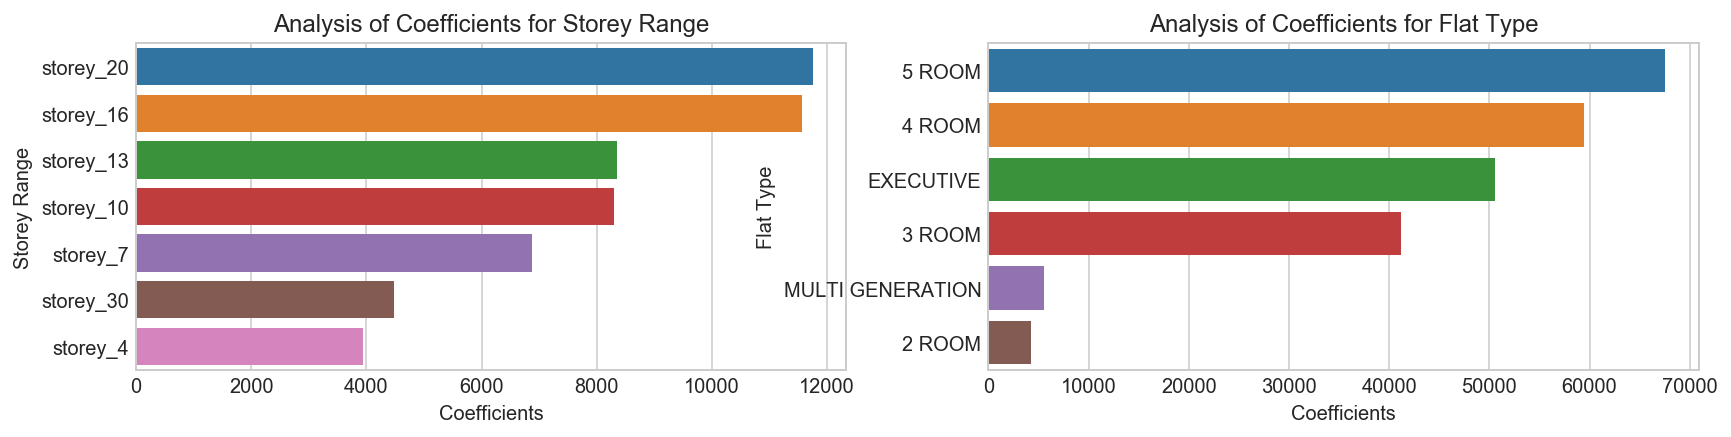

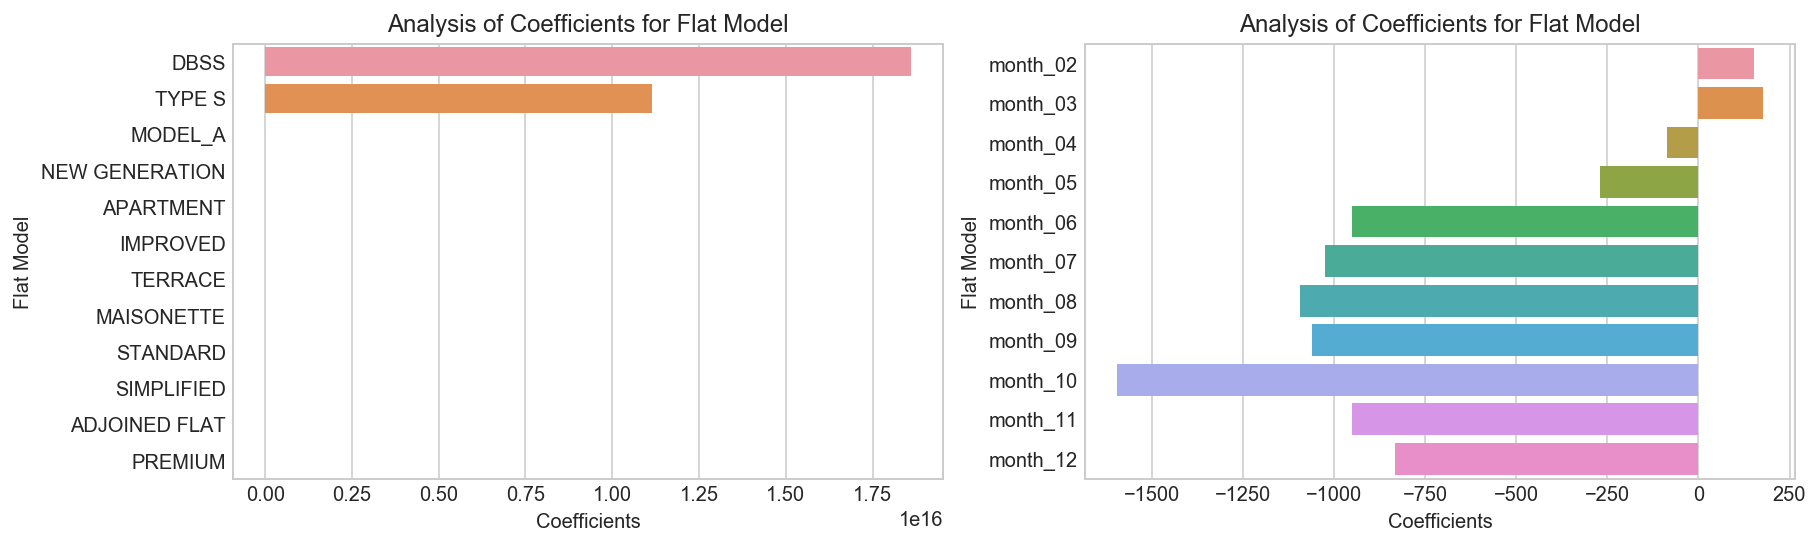

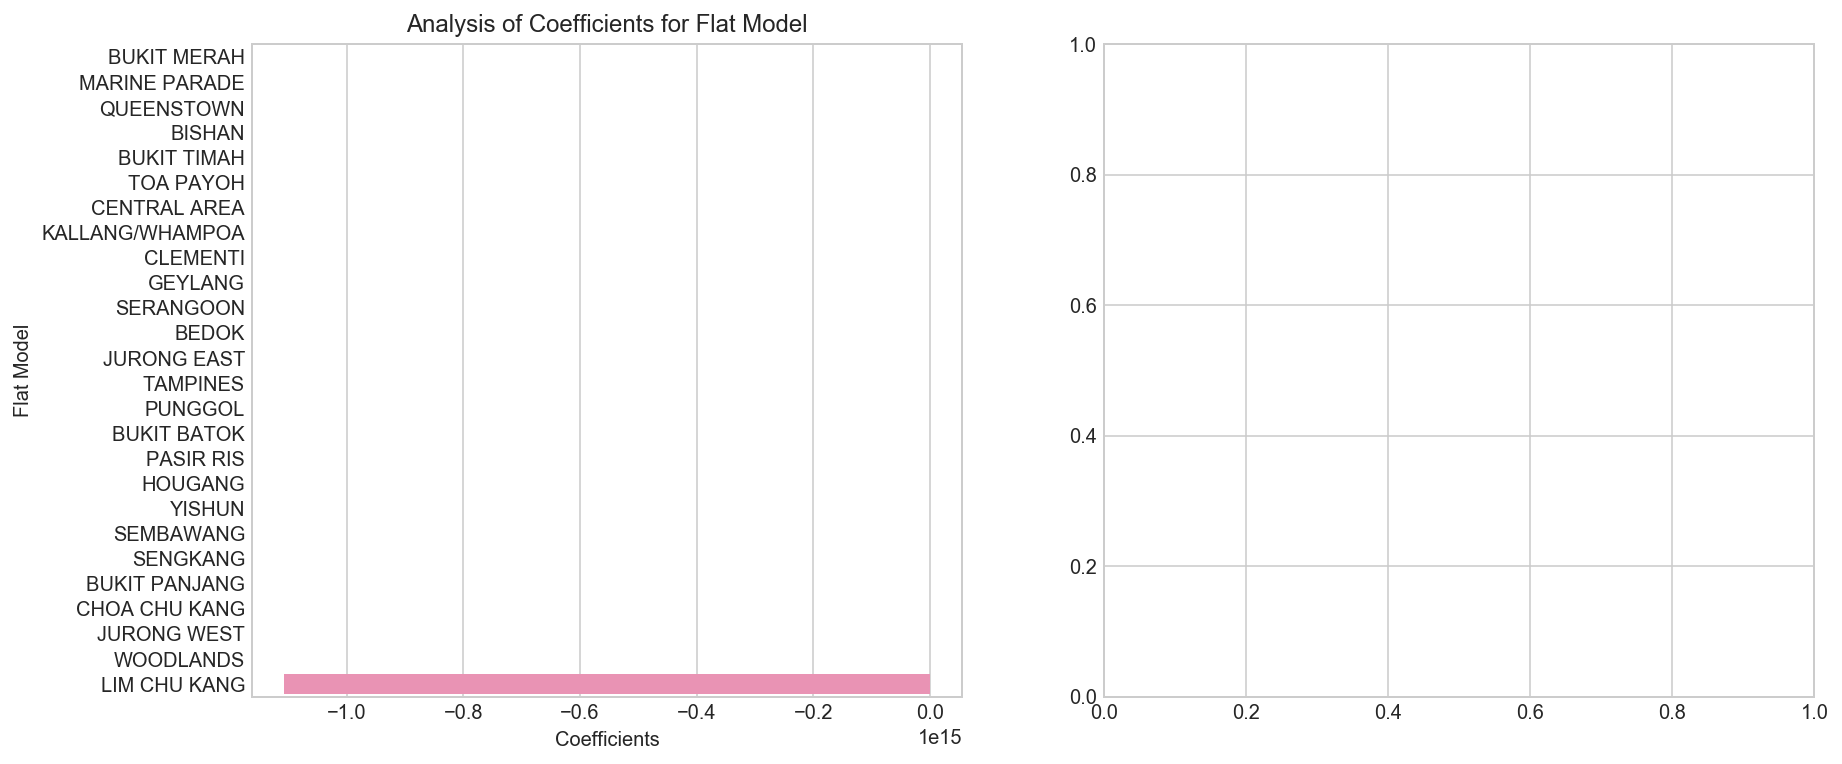

In [32]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic linreg',summary_model,[])
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='3aregularization'></a>
#### Iteration 3a: Ridge, Lasso, enet 

Mean of scores: 0.824595504834 | Std of scores: 0.031887144977
Test score: 0.744709625554
64 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_TYPE S', 'town_LIM CHU KANG']
        abs_coef          coef             variable
15  67205.675871  67205.675871     flat_type_5 ROOM
14  59129.380037  59129.380037     flat_type_4 ROOM
16  50317.796222  50317.796222  flat_type_EXECUTIVE
65  41821.041900  41821.041900       floor_area_sqm
13  40876.705536  40876.705536     flat_type_3 ROOM
60  25024.111103 -25024.111103       town_WOODLANDS
48  22593.104607 -22593.104607     town_JURONG WEST
43  19078.535571 -19078.535571   town_CHOA CHU KANG
66  18797.640739  18797.640739  lease_commence_date
40  16950.075203 -16950.075203   town_BUKIT PANJANG


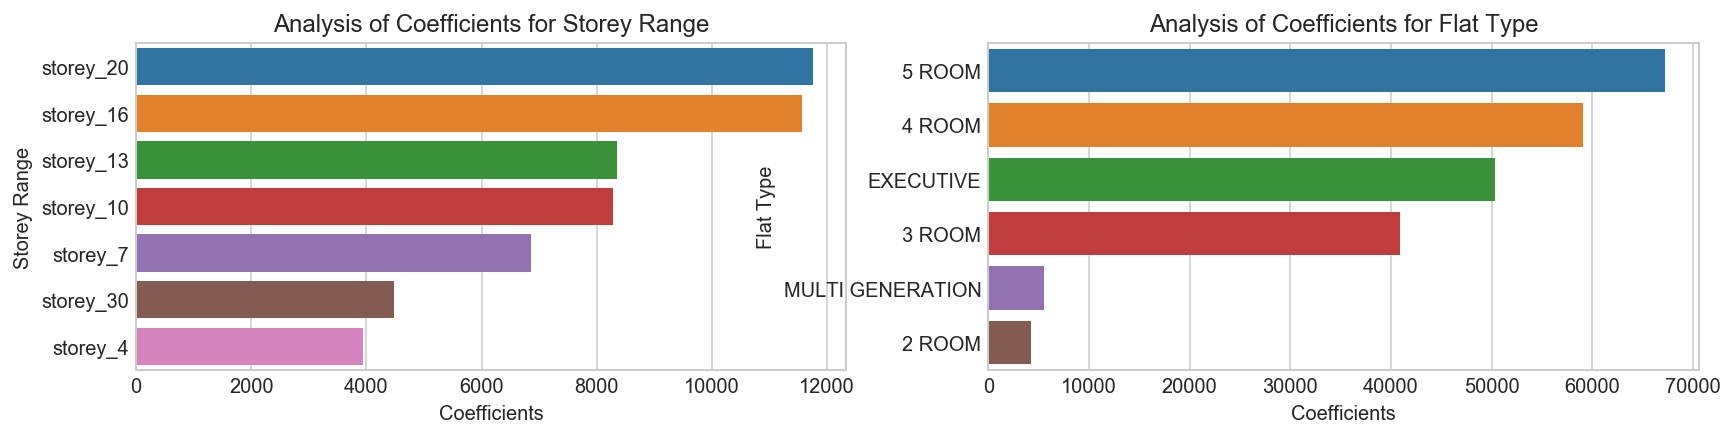

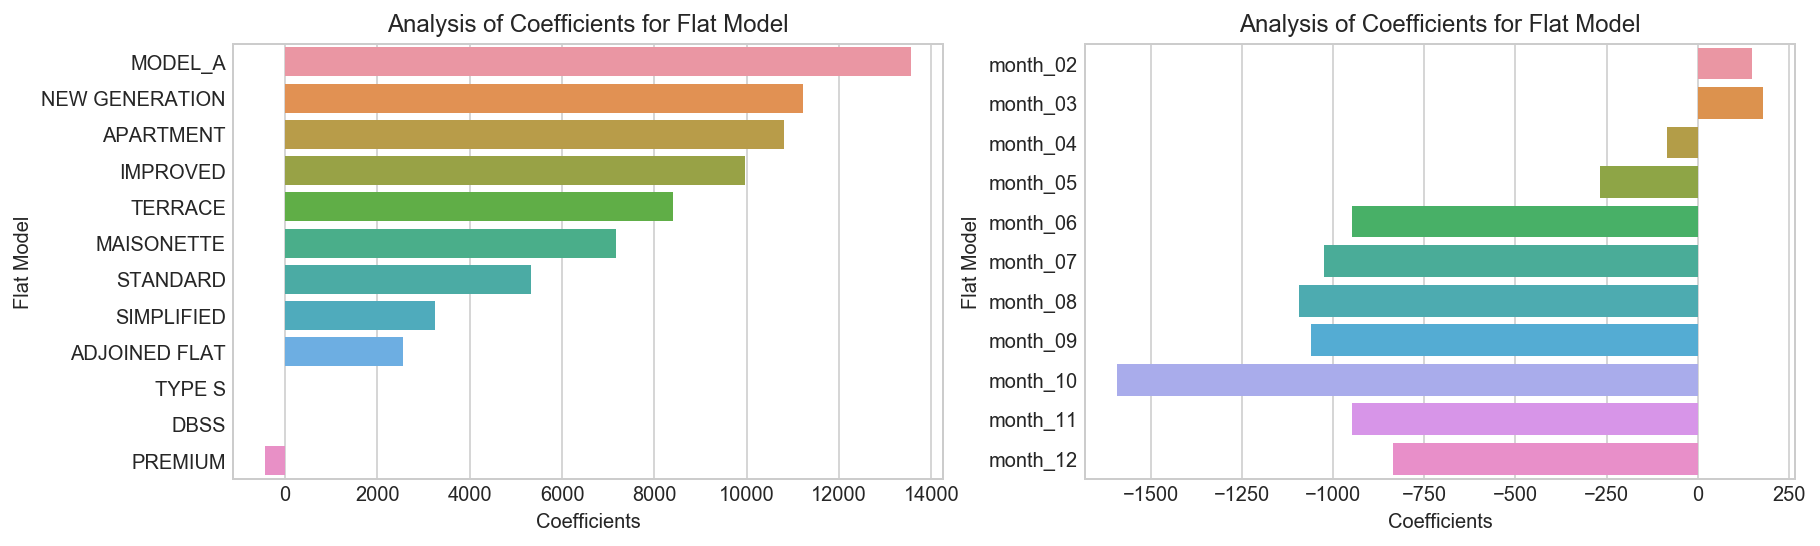

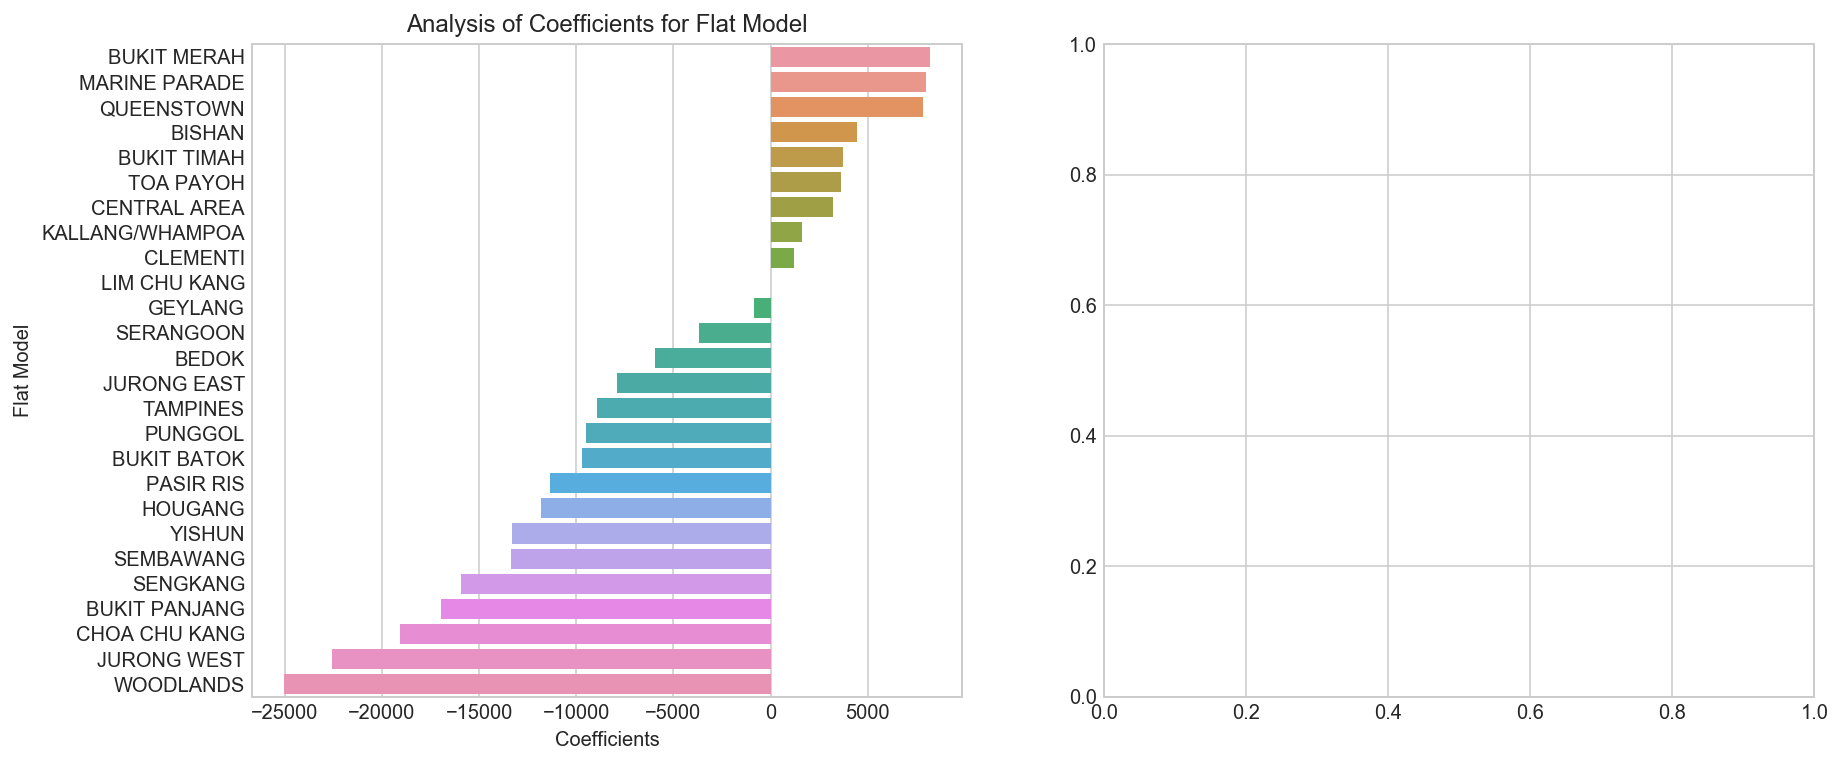

In [33]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.824262044139 | Std of scores: 0.0301992027918
Test score: 0.749188160967
60 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'month_str_05', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
65  46073.897747  46073.897747       floor_area_sqm
15  24658.482030  24658.482030     flat_type_5 ROOM
60  23493.968009 -23493.968009       town_WOODLANDS
16  22254.501695  22254.501695  flat_type_EXECUTIVE
48  21420.771555 -21420.771555     town_JURONG WEST
66  18955.177105  18955.177105  lease_commence_date
43  18106.948100 -18106.948100   town_CHOA CHU KANG
40  16012.289691 -16012.289691   town_BUKIT PANJANG
56  14694.643579 -14694.643579        town_SENGKANG
14  13254.616710  13254.616710     flat_type_4 ROOM


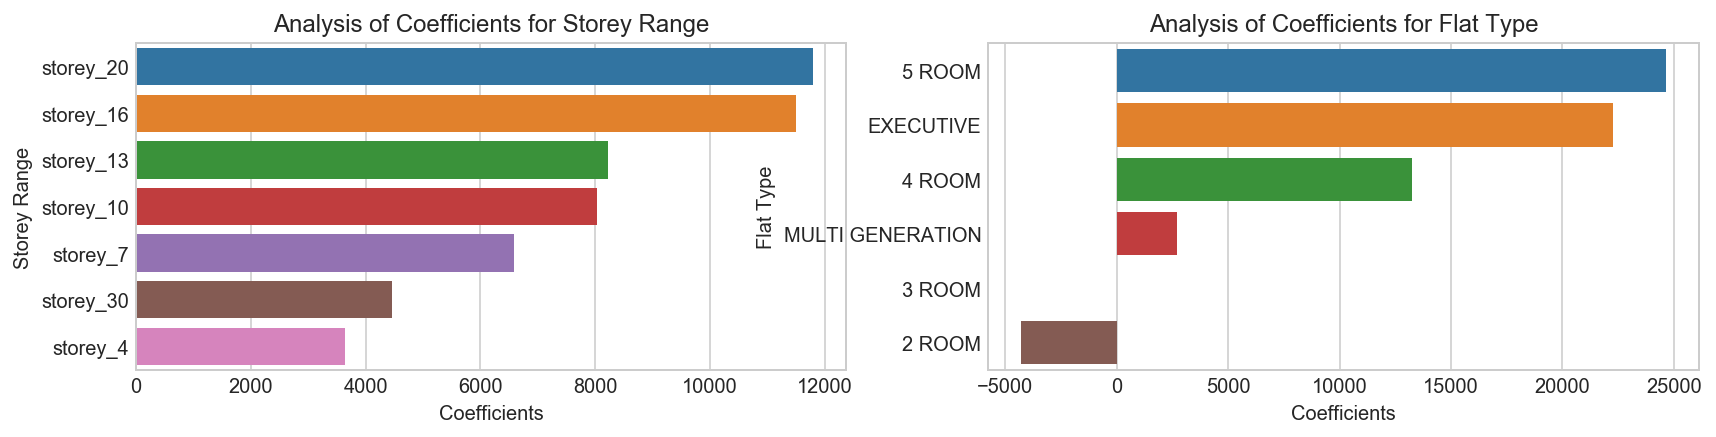

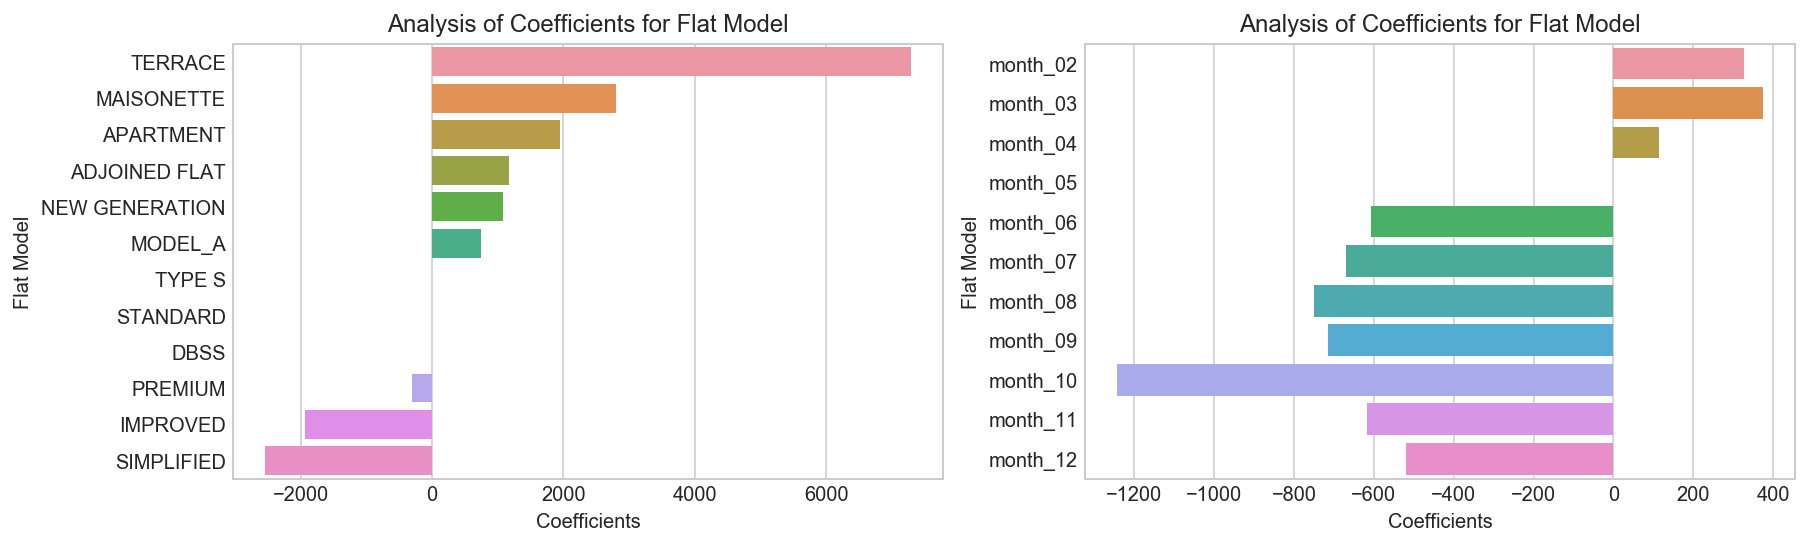

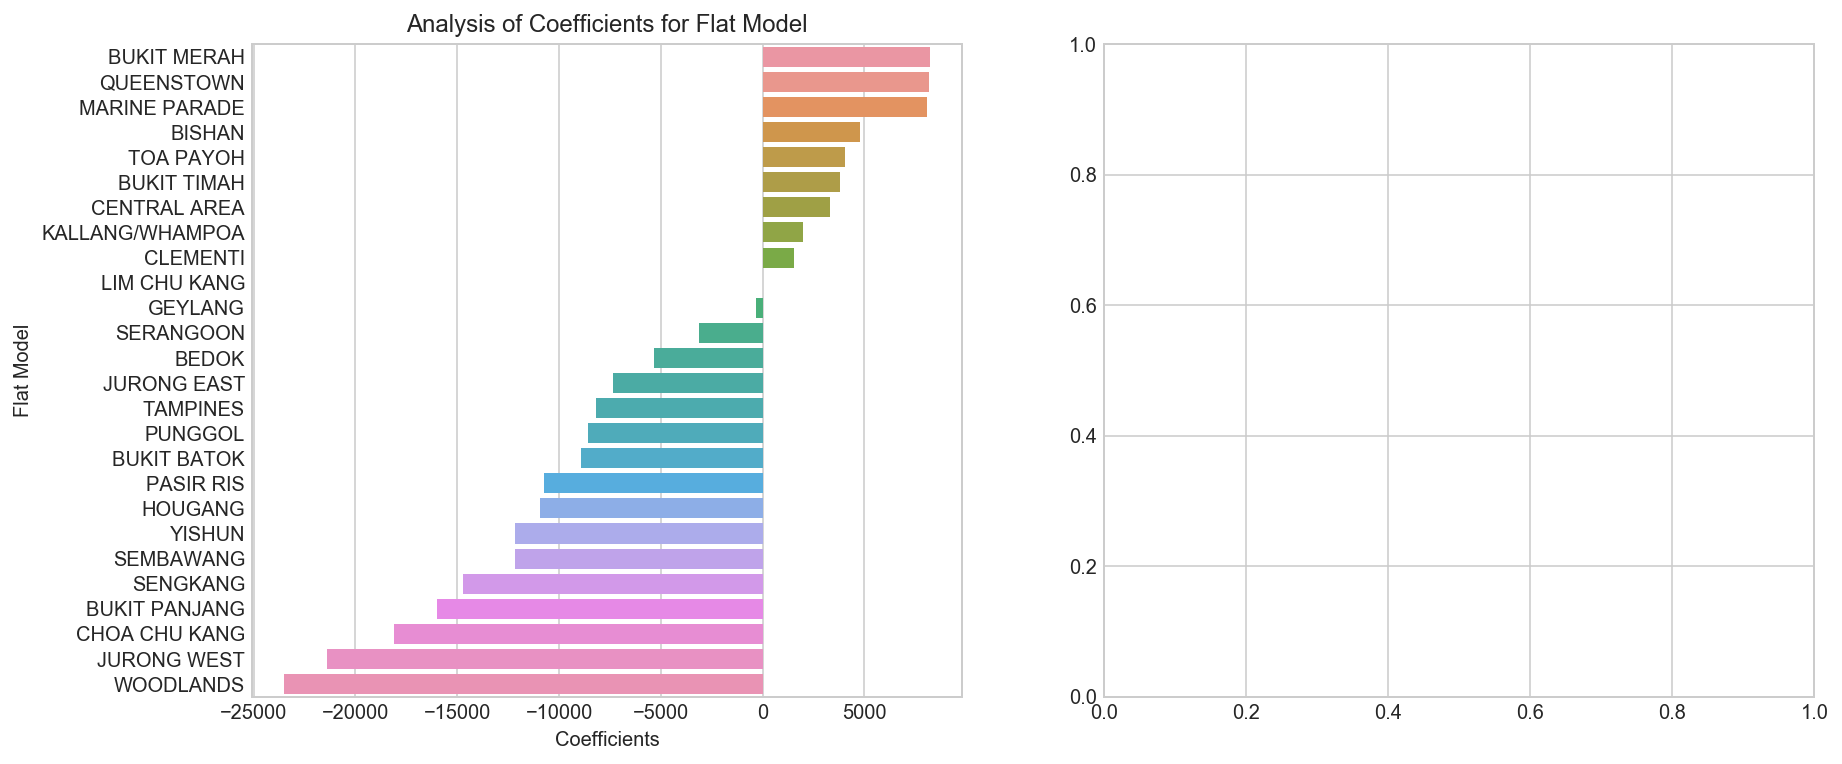

In [34]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.824262044139 | Std of scores: 0.0301992027918
Test score: 0.749188160967
60 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'month_str_05', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
65  46073.897747  46073.897747       floor_area_sqm
15  24658.482030  24658.482030     flat_type_5 ROOM
60  23493.968009 -23493.968009       town_WOODLANDS
16  22254.501695  22254.501695  flat_type_EXECUTIVE
48  21420.771555 -21420.771555     town_JURONG WEST
66  18955.177105  18955.177105  lease_commence_date
43  18106.948100 -18106.948100   town_CHOA CHU KANG
40  16012.289691 -16012.289691   town_BUKIT PANJANG
56  14694.643579 -14694.643579        town_SENGKANG
14  13254.616710  13254.616710     flat_type_4 ROOM


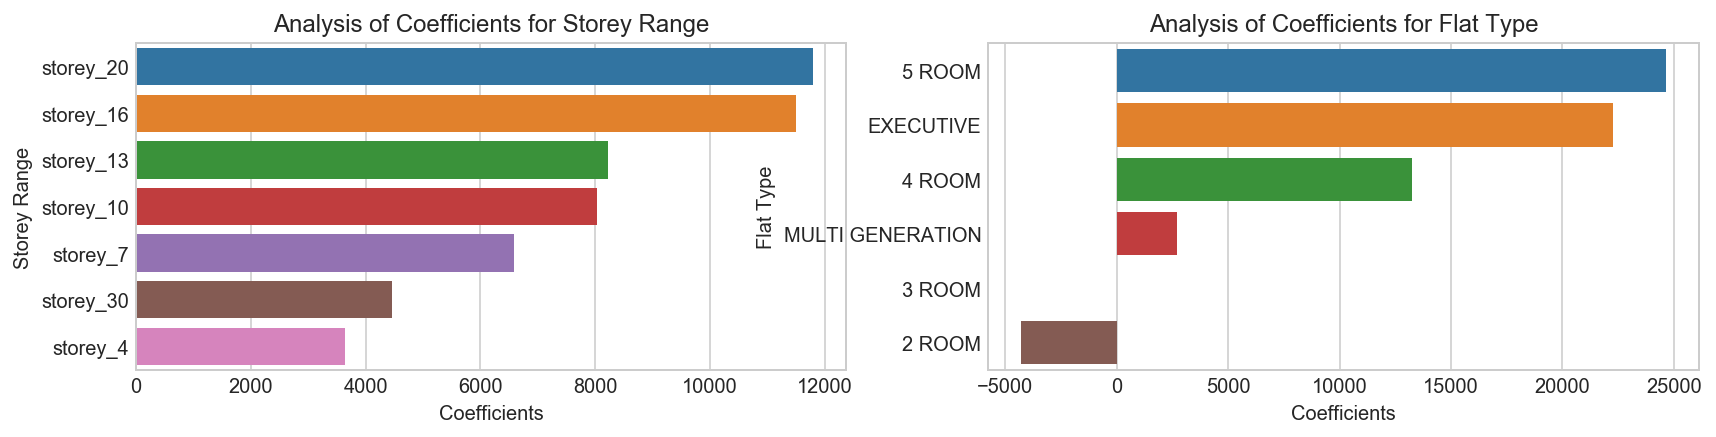

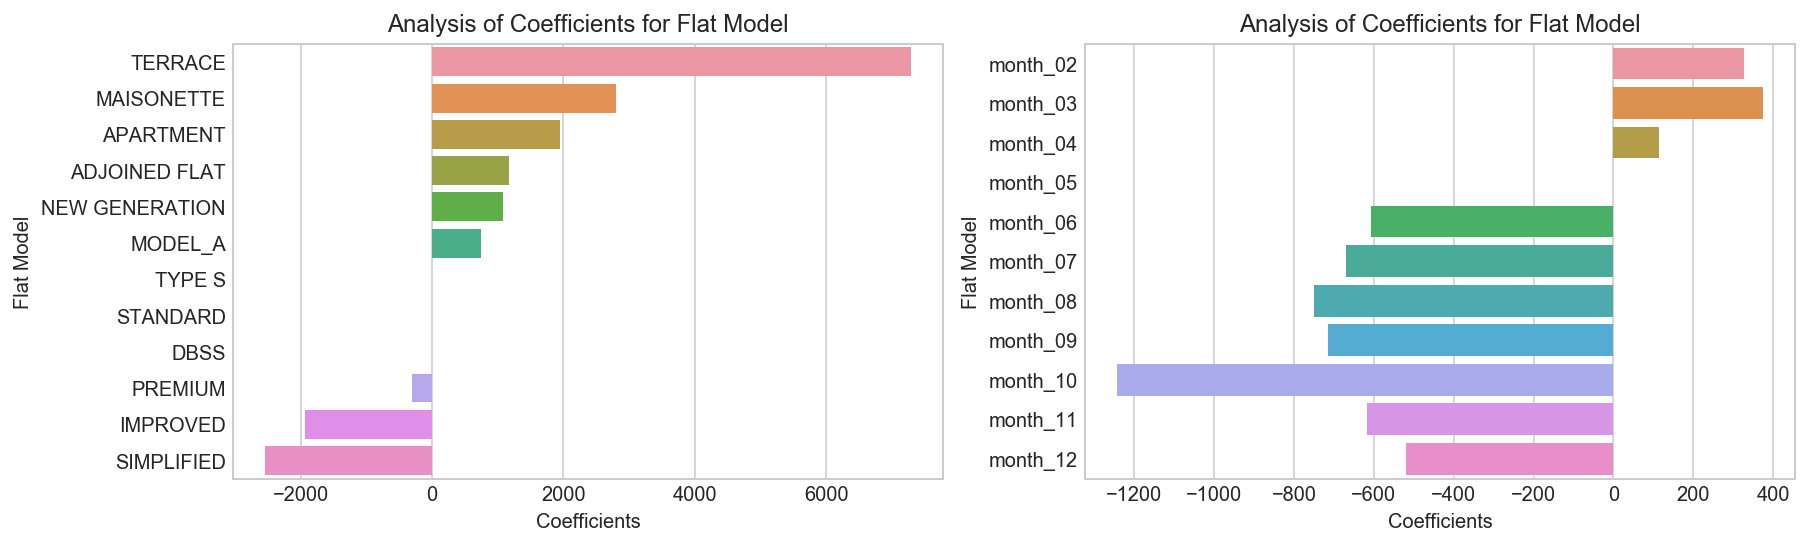

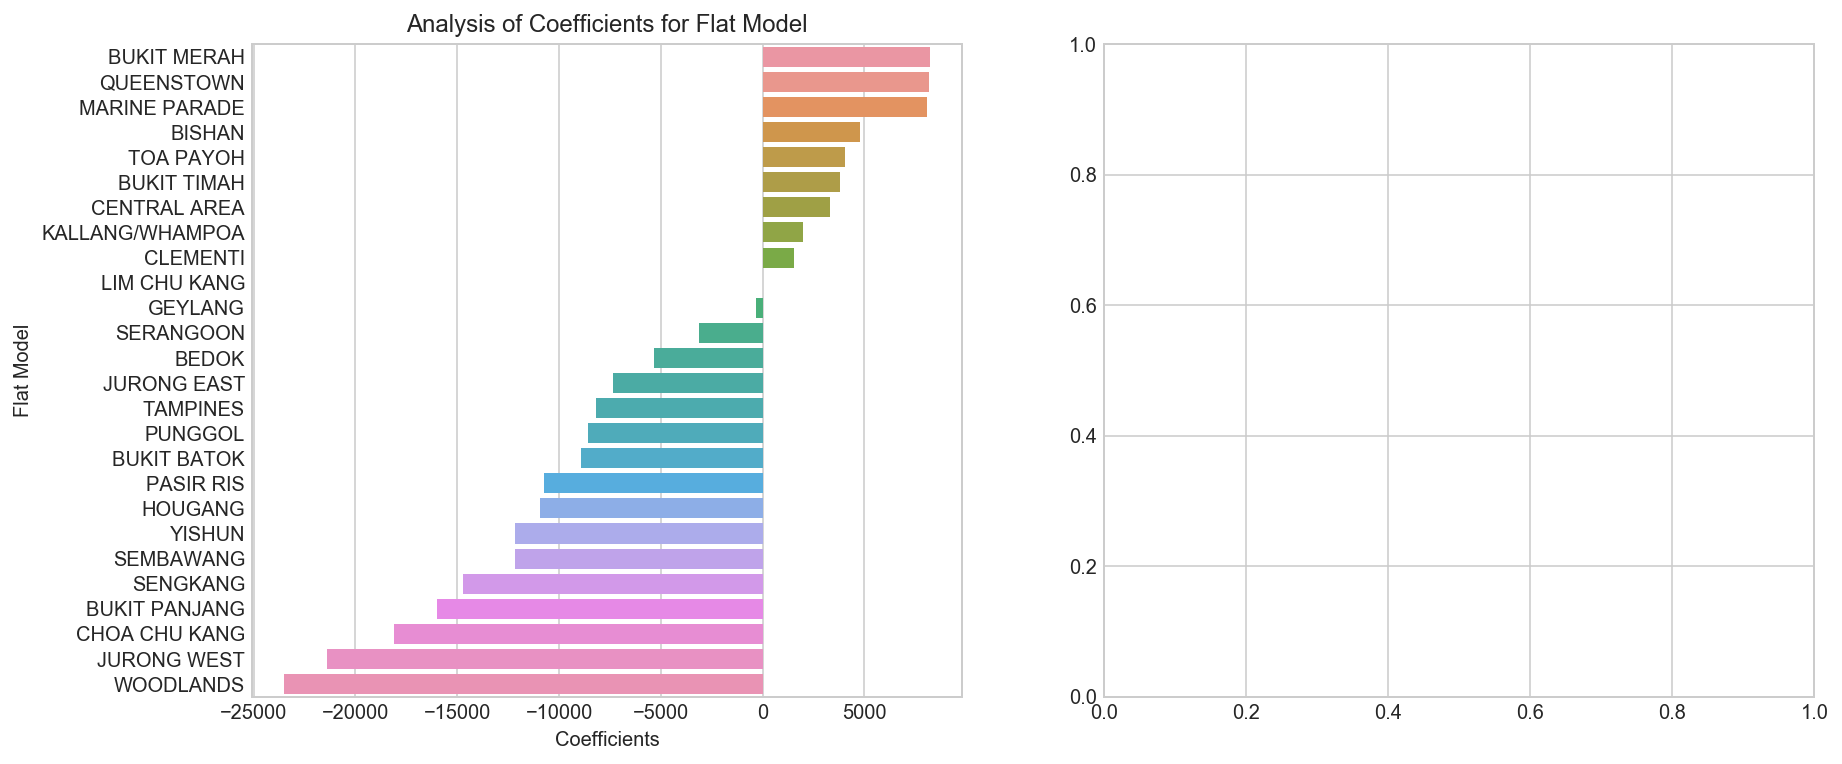

In [35]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

In [36]:
summary

,model,train_mean_score,train_std_score,test_score
0,iter3a_basic linreg,0.824598,0.0318836,-1.82903e+20
0,iter3a_basic ridge,0.824596,0.0318871,0.74471
0,iter3a_basic lasso,0.824262,0.0301992,0.749188
0,iter3a_basic enet,0.824262,0.0301992,0.749188


<a id='iter3b'></a>
### Iteration 3b

In [37]:
df = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col and 'month' not in col]],df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)

train = df[(df['year']<2014)&(df['year']>2004)]
test = df[df['year']>=2014]

X = df.drop(['var_resale_price','var_adj_price','year'],axis=1)
X_train = train.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_train = train['var_resale_price']
X_test = test.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_test = test['var_resale_price']


<a id='3bmlrall'></a>
#### Iteration 3b: Multiple variable Linear regression: ALL 

Mean of scores: 0.824900439331 | Std of scores: 0.0318323193893
Test score: -1.75200033395e+19
56 out of 56 features are selected.
Coefficients not used: []
        abs_coef          coef             variable
5   5.918459e+15 -5.918459e+15      flat_model_DBSS
11  2.674281e+15  2.674281e+15    flat_model_TYPE S
39  1.141141e+10 -1.141141e+10    town_LIM CHU KANG
15  6.732875e+04  6.732875e+04     flat_type_5 ROOM
14  5.934875e+04  5.934875e+04     flat_type_4 ROOM
16  5.037700e+04  5.037700e+04  flat_type_EXECUTIVE
54  4.188725e+04  4.188725e+04       floor_area_sqm
13  4.112175e+04  4.112175e+04     flat_type_3 ROOM
49  2.489788e+04 -2.489788e+04       town_WOODLANDS
37  2.253056e+04 -2.253056e+04     town_JURONG WEST


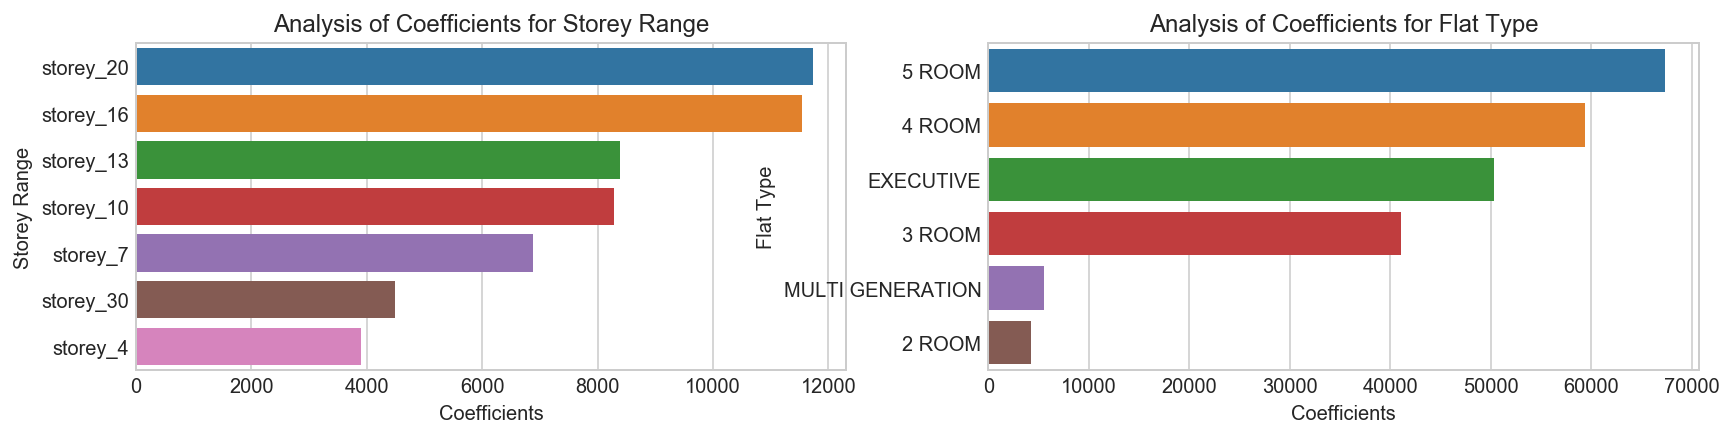

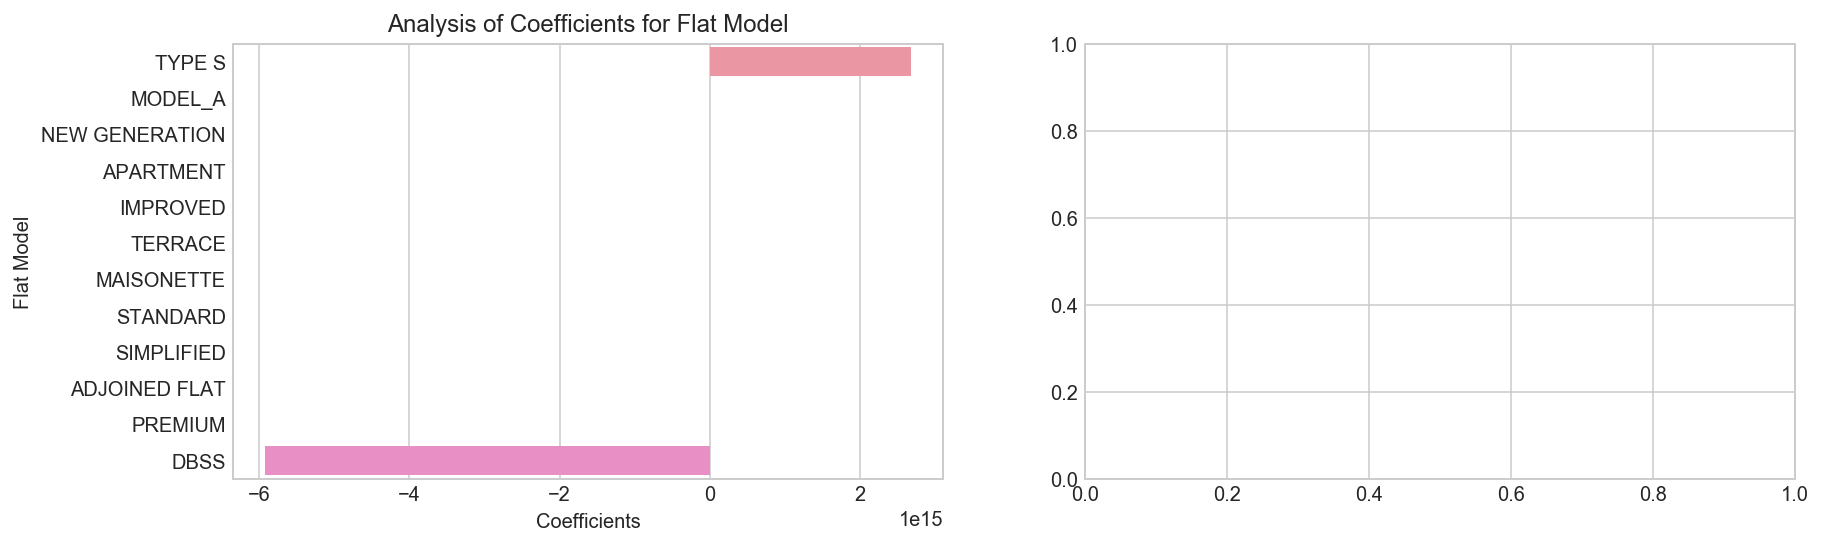

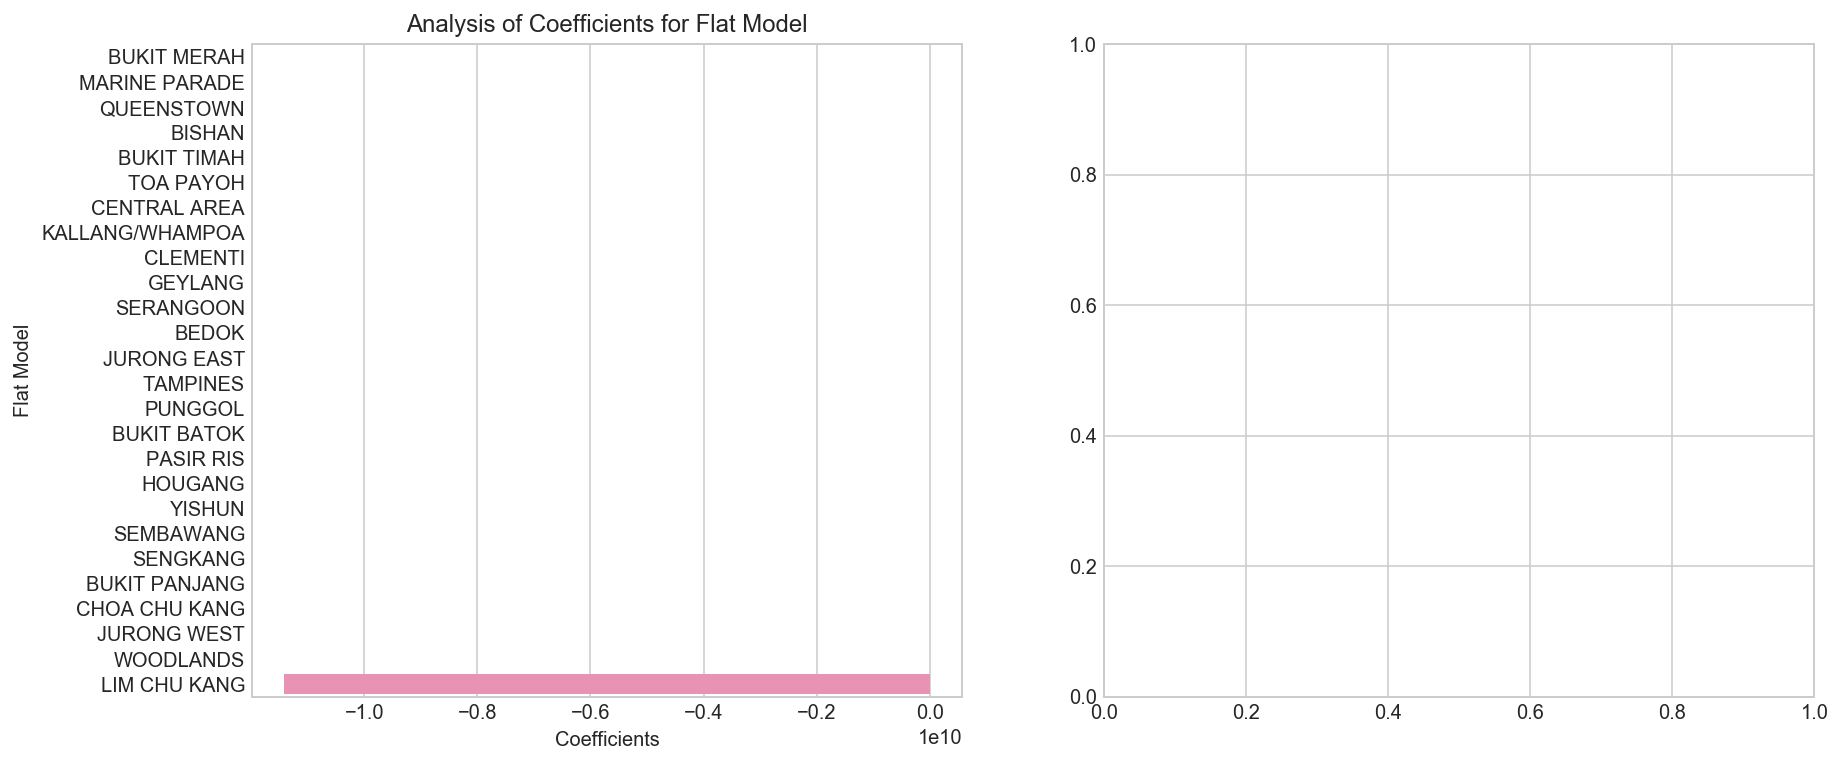

In [38]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic linreg',summary_model,summary)
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='3bregularization'></a>
#### Iteration 3b: Ridge, Lasso, enet

Mean of scores: 0.824903280857 | Std of scores: 0.0318565111459
Test score: 0.744848388572
53 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_TYPE S', 'town_LIM CHU KANG']
        abs_coef          coef             variable
15  67082.313754  67082.313754     flat_type_5 ROOM
14  59065.271389  59065.271389     flat_type_4 ROOM
16  50212.251870  50212.251870  flat_type_EXECUTIVE
54  41874.083989  41874.083989       floor_area_sqm
13  40835.893243  40835.893243     flat_type_3 ROOM
49  24974.816153 -24974.816153       town_WOODLANDS
37  22552.302102 -22552.302102     town_JURONG WEST
32  19054.056721 -19054.056721   town_CHOA CHU KANG
55  18839.122745  18839.122745  lease_commence_date
29  16938.987396 -16938.987396   town_BUKIT PANJANG


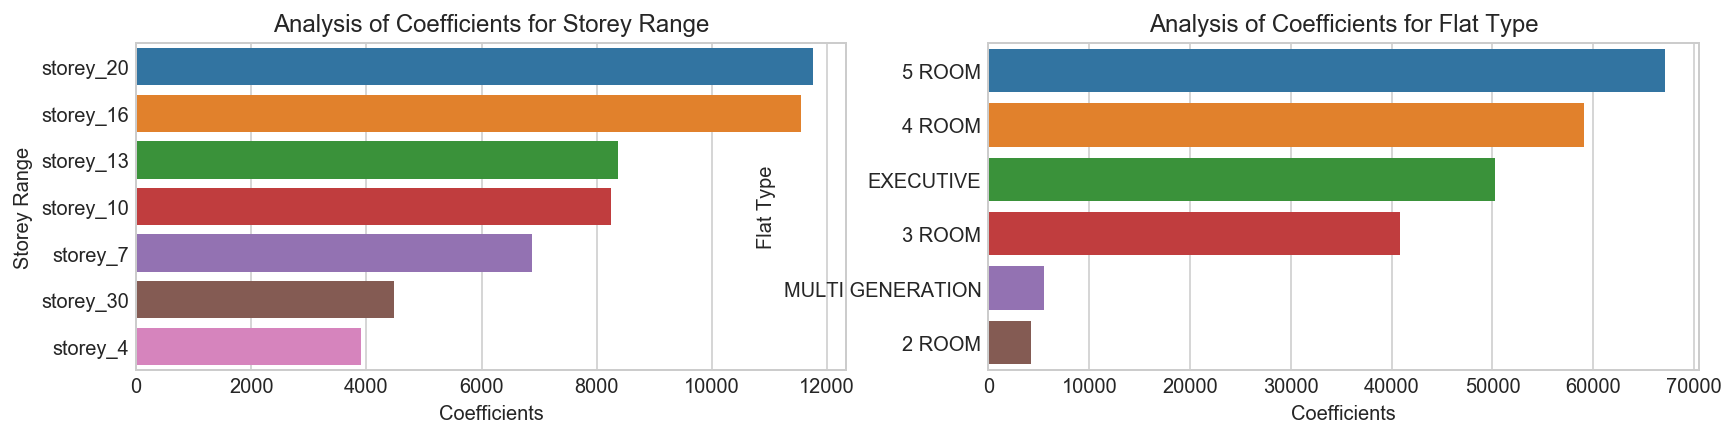

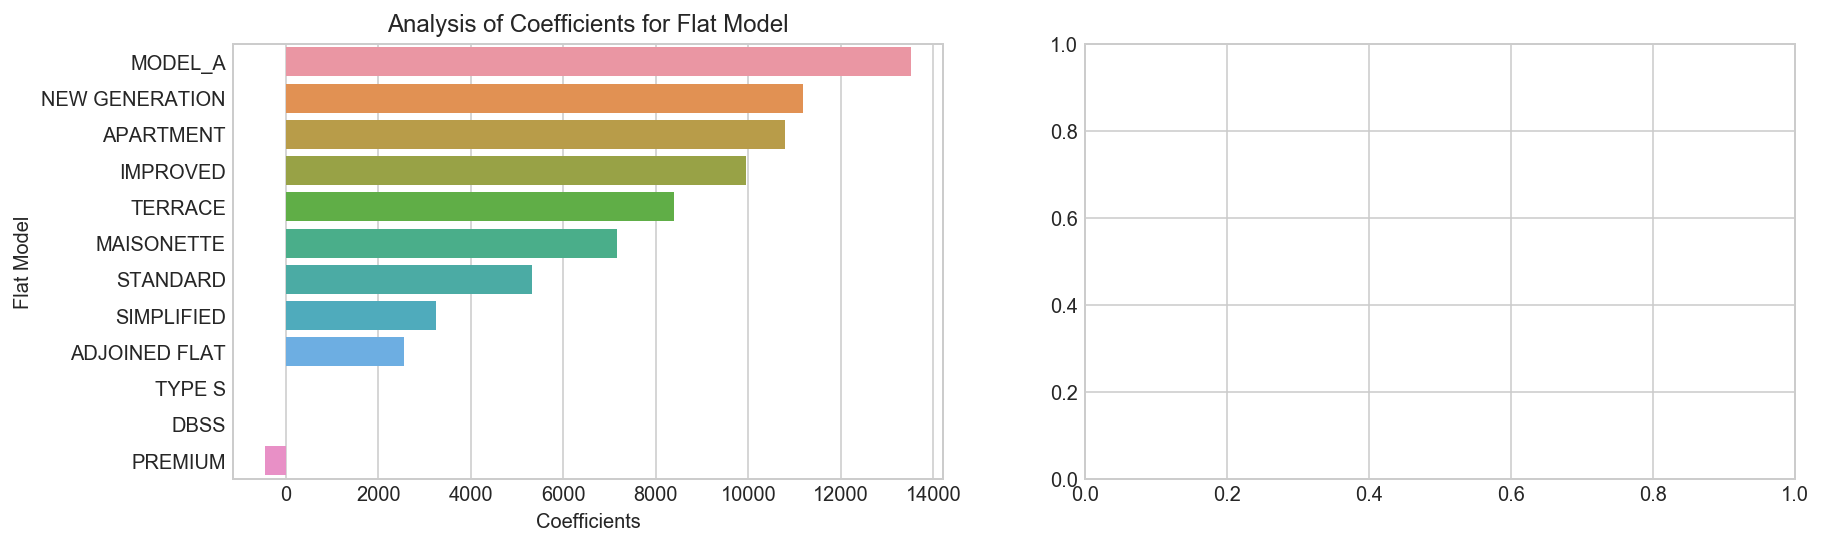

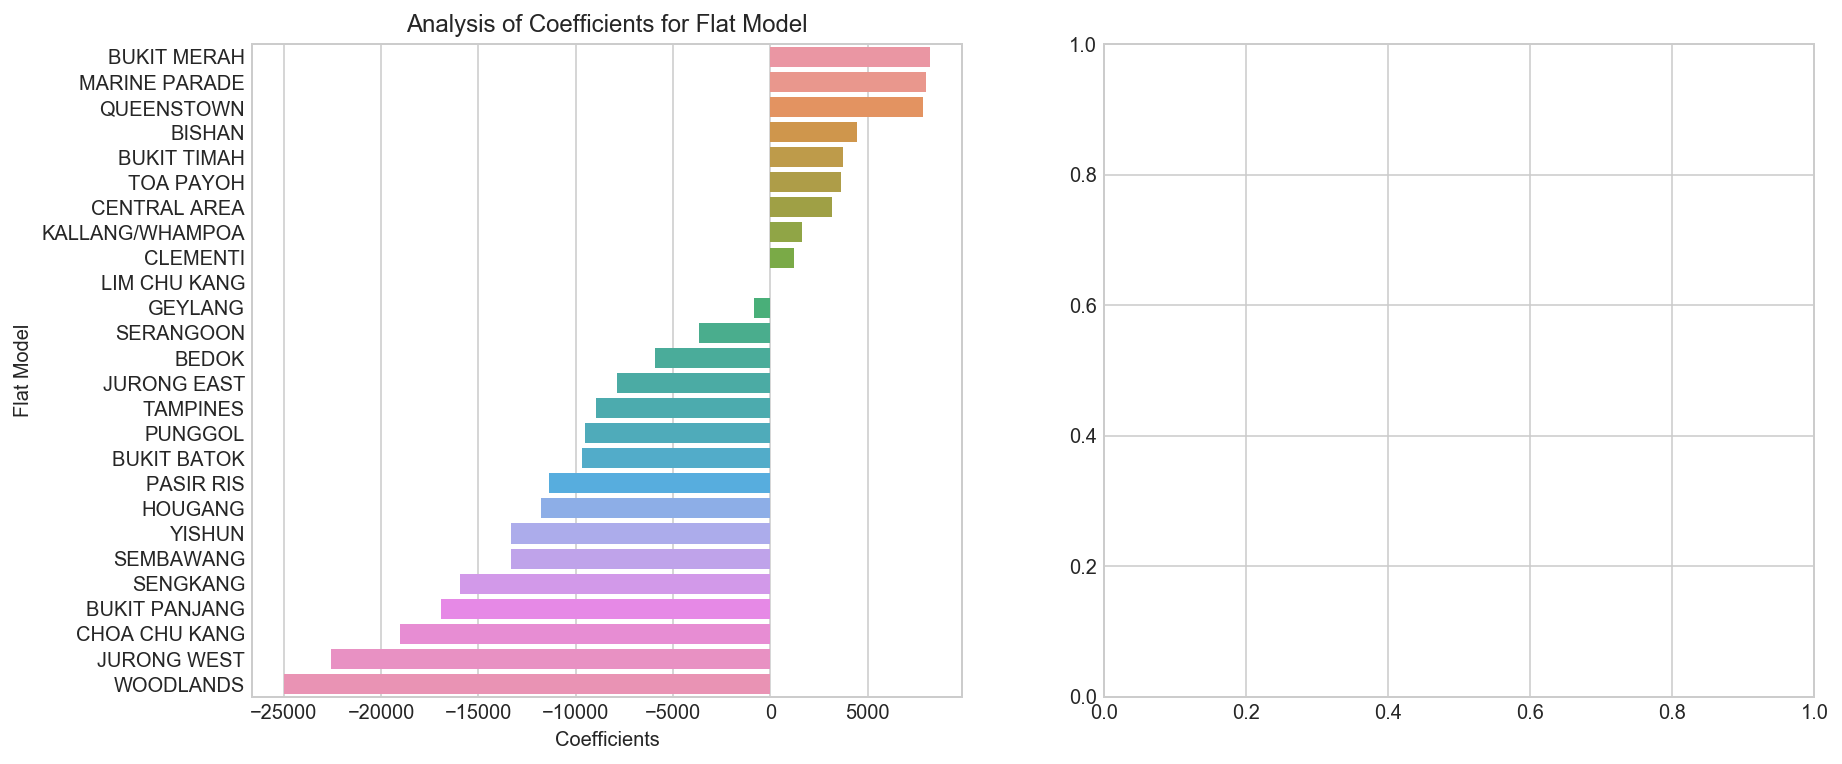

In [39]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.824495422918 | Std of scores: 0.0302625009789
Test score: 0.749311034365
50 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
54  46121.334217  46121.334217       floor_area_sqm
15  24582.835274  24582.835274     flat_type_5 ROOM
49  23458.582907 -23458.582907       town_WOODLANDS
16  22183.806024  22183.806024  flat_type_EXECUTIVE
37  21399.459691 -21399.459691     town_JURONG WEST
55  18991.274856  18991.274856  lease_commence_date
32  18093.783277 -18093.783277   town_CHOA CHU KANG
29  16007.855888 -16007.855888   town_BUKIT PANJANG
45  14690.615819 -14690.615819        town_SENGKANG
14  13237.083962  13237.083962     flat_type_4 ROOM


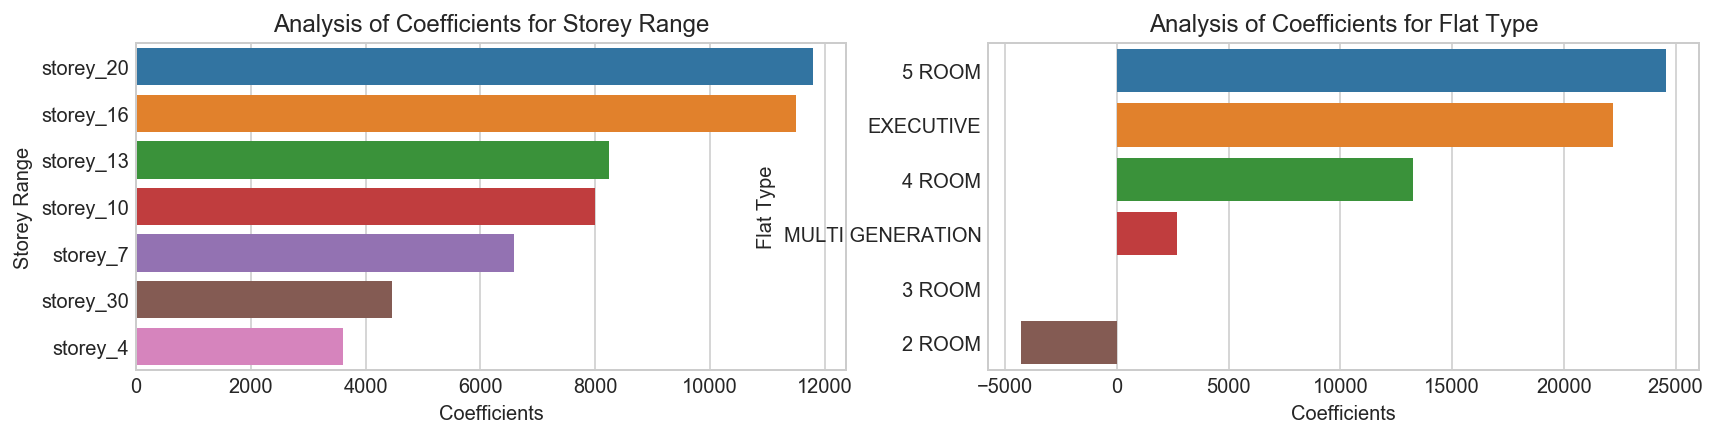

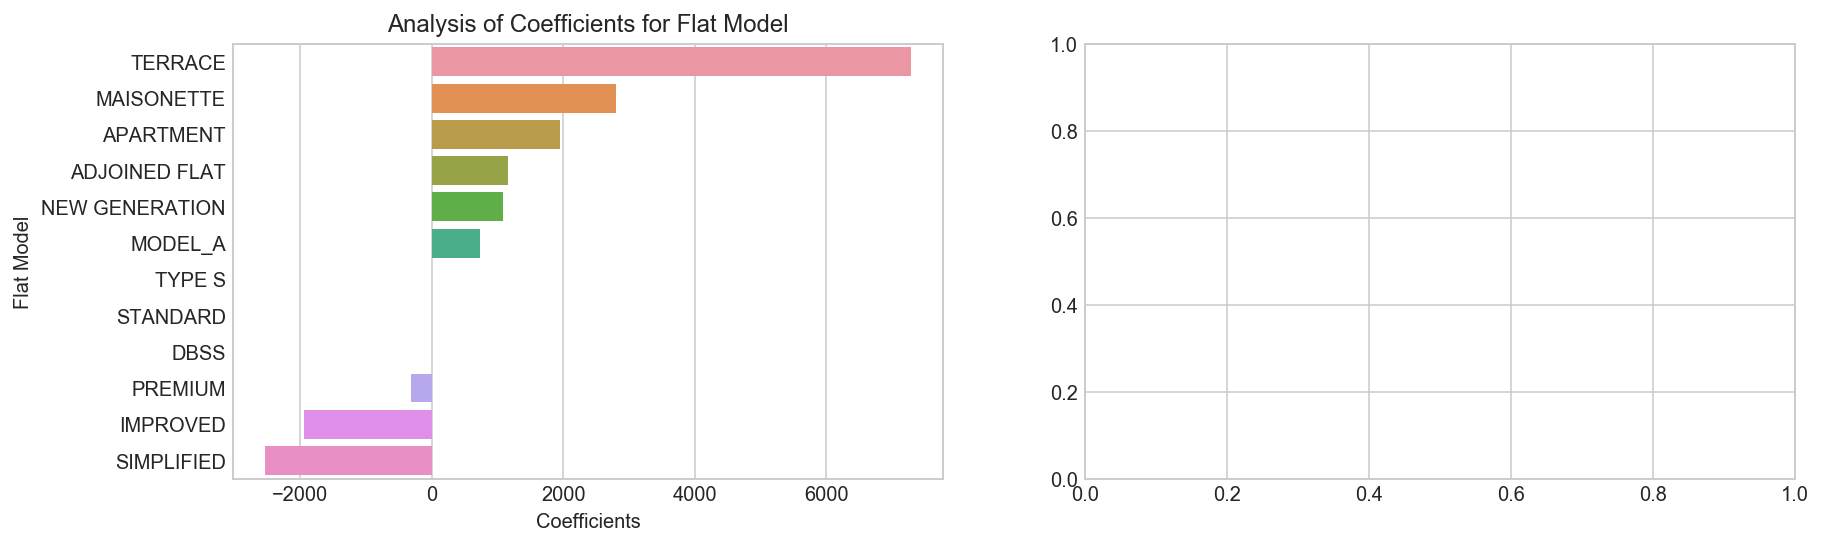

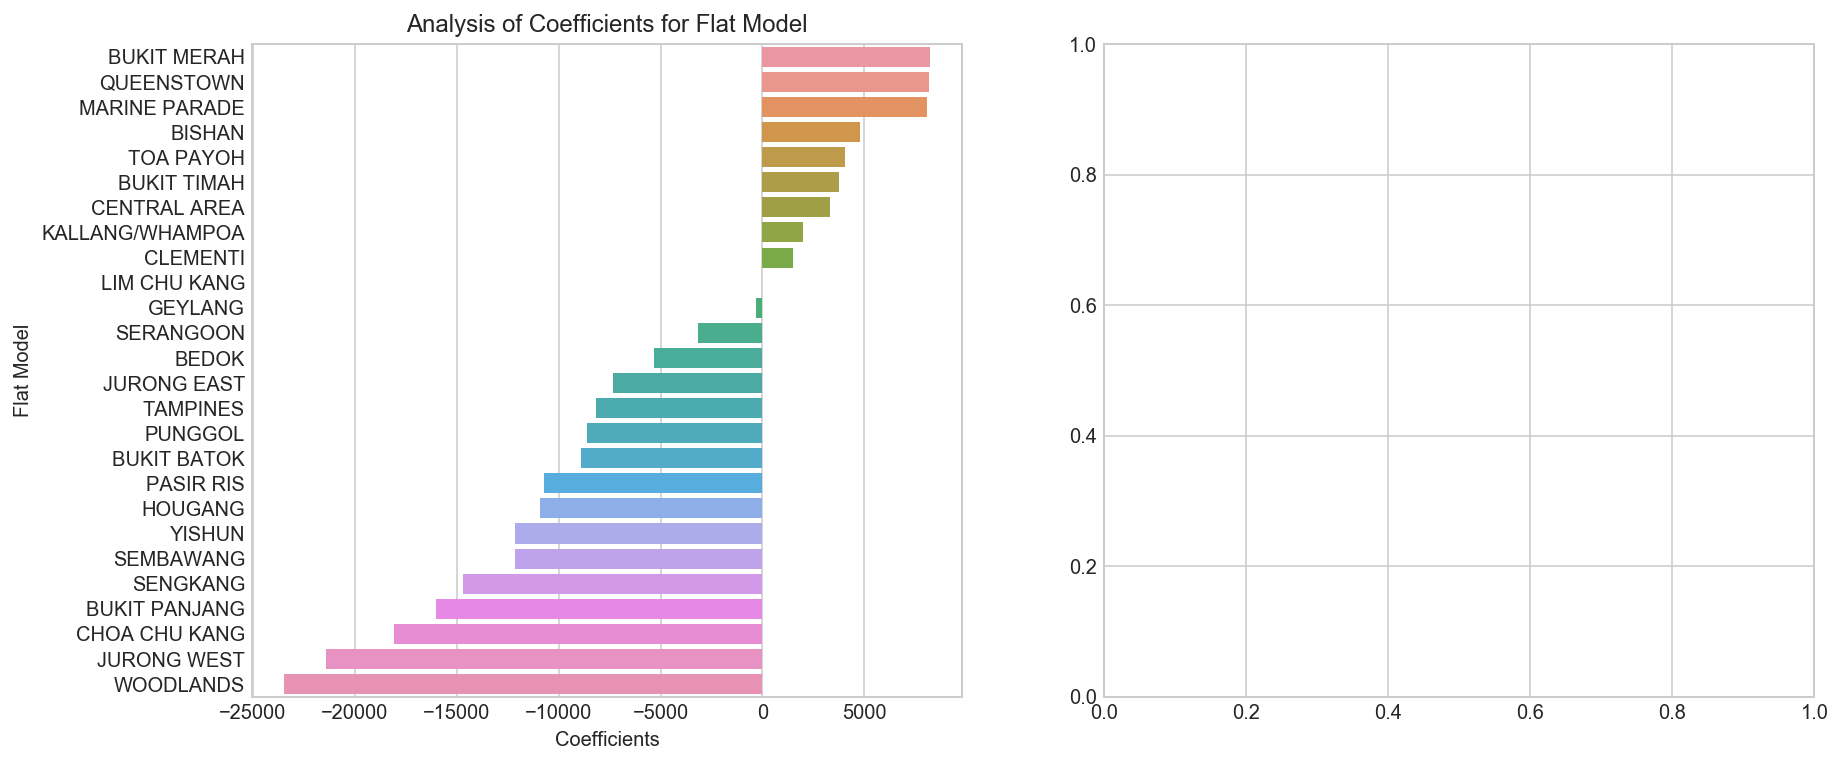

In [40]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.824495422918 | Std of scores: 0.0302625009789
Test score: 0.749311034365
50 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
54  46121.334217  46121.334217       floor_area_sqm
15  24582.835274  24582.835274     flat_type_5 ROOM
49  23458.582907 -23458.582907       town_WOODLANDS
16  22183.806024  22183.806024  flat_type_EXECUTIVE
37  21399.459691 -21399.459691     town_JURONG WEST
55  18991.274856  18991.274856  lease_commence_date
32  18093.783277 -18093.783277   town_CHOA CHU KANG
29  16007.855888 -16007.855888   town_BUKIT PANJANG
45  14690.615819 -14690.615819        town_SENGKANG
14  13237.083962  13237.083962     flat_type_4 ROOM


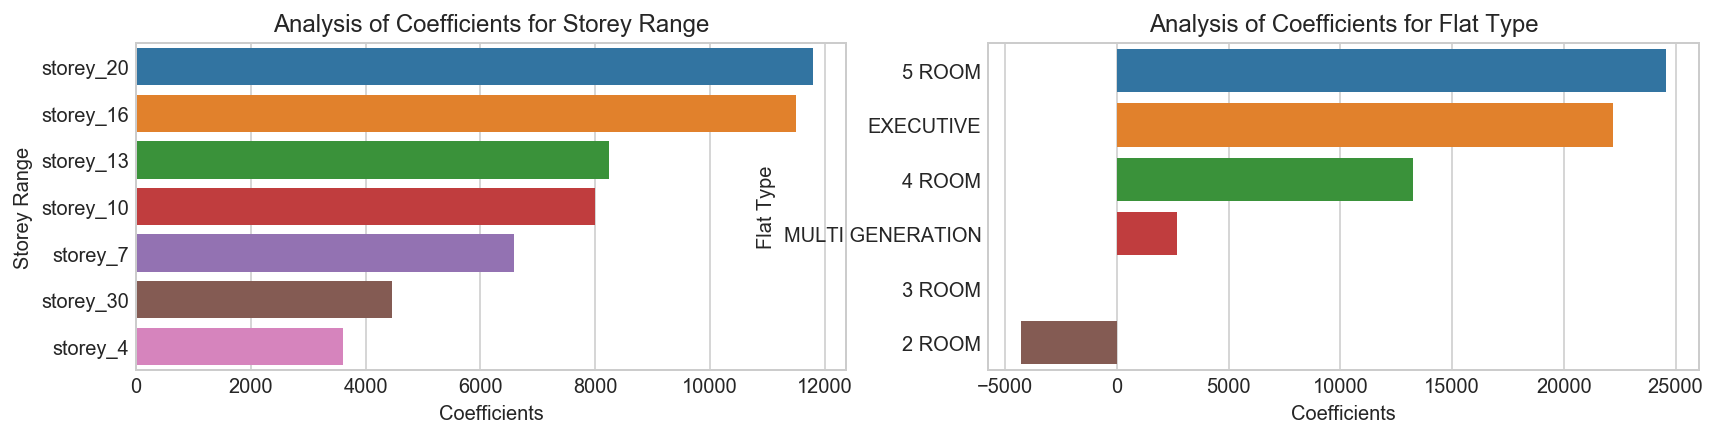

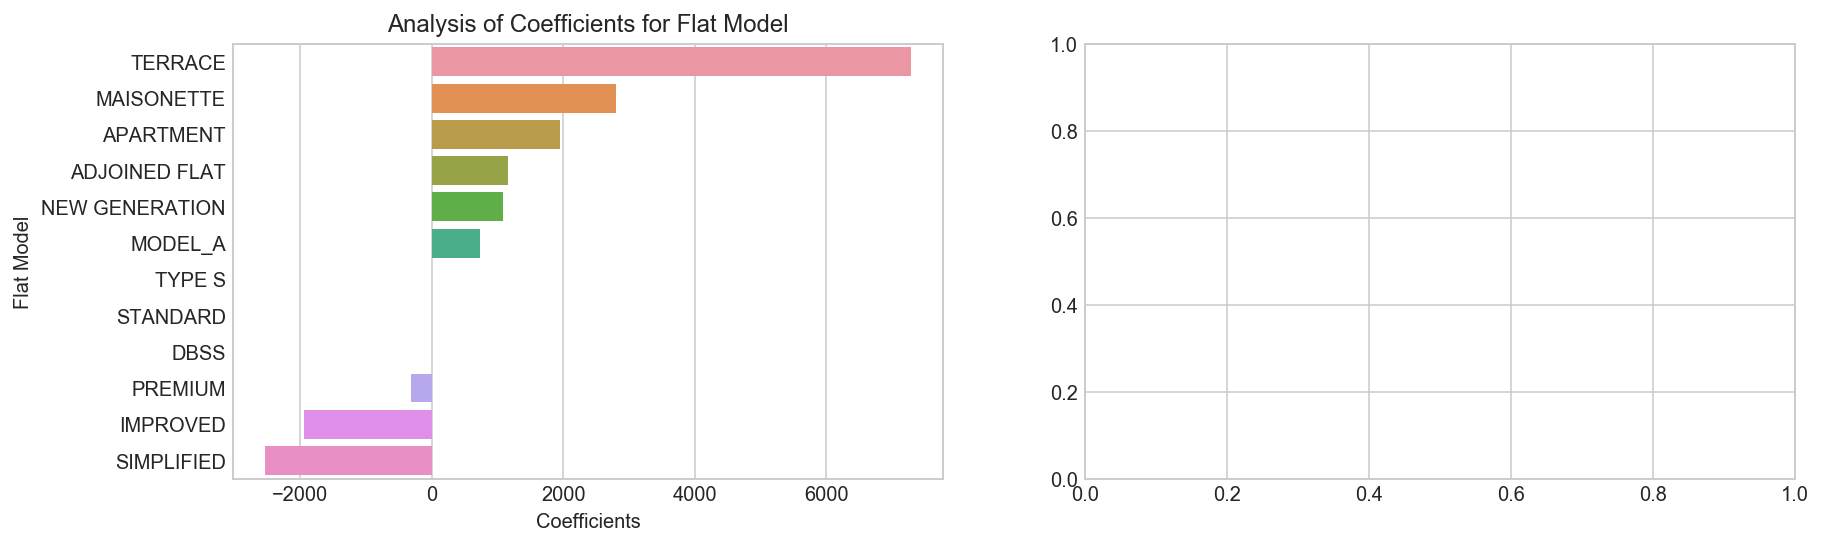

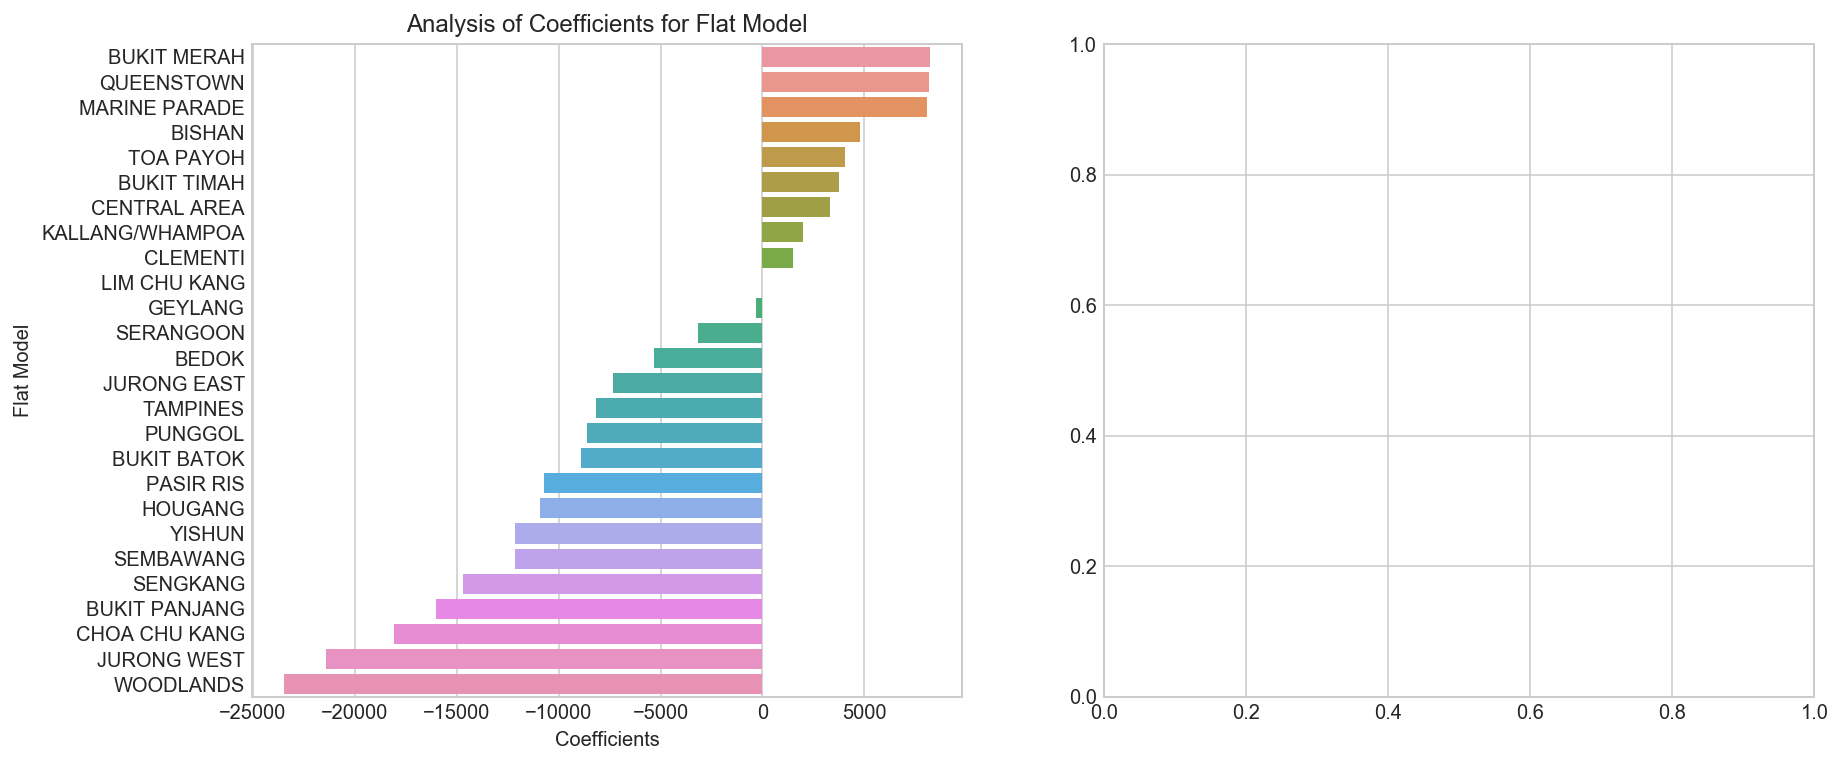

In [41]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

##### Insights 

In [42]:
summary.sort_values('train_mean_score',ascending = False)

,model,train_mean_score,train_std_score,test_score
0,iter3b_basic ridge,0.824903,0.0318565,0.744848
0,iter3b_basic linreg,0.8249,0.0318323,-1.752e+19
0,iter3a_basic linreg,0.824598,0.0318836,-1.82903e+20
0,iter3a_basic ridge,0.824596,0.0318871,0.74471
0,iter3b_basic lasso,0.824495,0.0302625,0.749311
0,iter3b_basic enet,0.824495,0.0302625,0.749311
0,iter3a_basic lasso,0.824262,0.0301992,0.749188
0,iter3a_basic enet,0.824262,0.0301992,0.749188


<a id='iter4a'></a>
### Iteration 4a

In [43]:
df = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col]],df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)
train = df[(df['year']<2014)&(df['year']>2004)]
test = df[df['year']>=2014]
X = df.drop(['var_resale_price','var_adj_price','year'],axis=1)
X_train = train.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_train = train['var_adj_price']
X_test = test.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_test = test['var_adj_price']


<a id='4amlrall'></a>
#### Iteration 4a: Multiple variable Linear regression: ALL 

Mean of scores: 0.851915447194 | Std of scores: 0.00865026333477
Test score: -4.88630993783e+20
67 out of 67 features are selected.
Coefficients not used: []
        abs_coef          coef             variable
5   3.038921e+16  3.038921e+16      flat_model_DBSS
11  1.526445e+16  1.526445e+16    flat_model_TYPE S
50  1.698486e+15 -1.698486e+15    town_LIM CHU KANG
15  7.716400e+04  7.716400e+04     flat_type_5 ROOM
14  6.794000e+04  6.794000e+04     flat_type_4 ROOM
16  5.640350e+04  5.640350e+04  flat_type_EXECUTIVE
65  4.956900e+04  4.956900e+04       floor_area_sqm
13  4.730200e+04  4.730200e+04     flat_type_3 ROOM
60  2.857700e+04 -2.857700e+04       town_WOODLANDS
48  2.613600e+04 -2.613600e+04     town_JURONG WEST


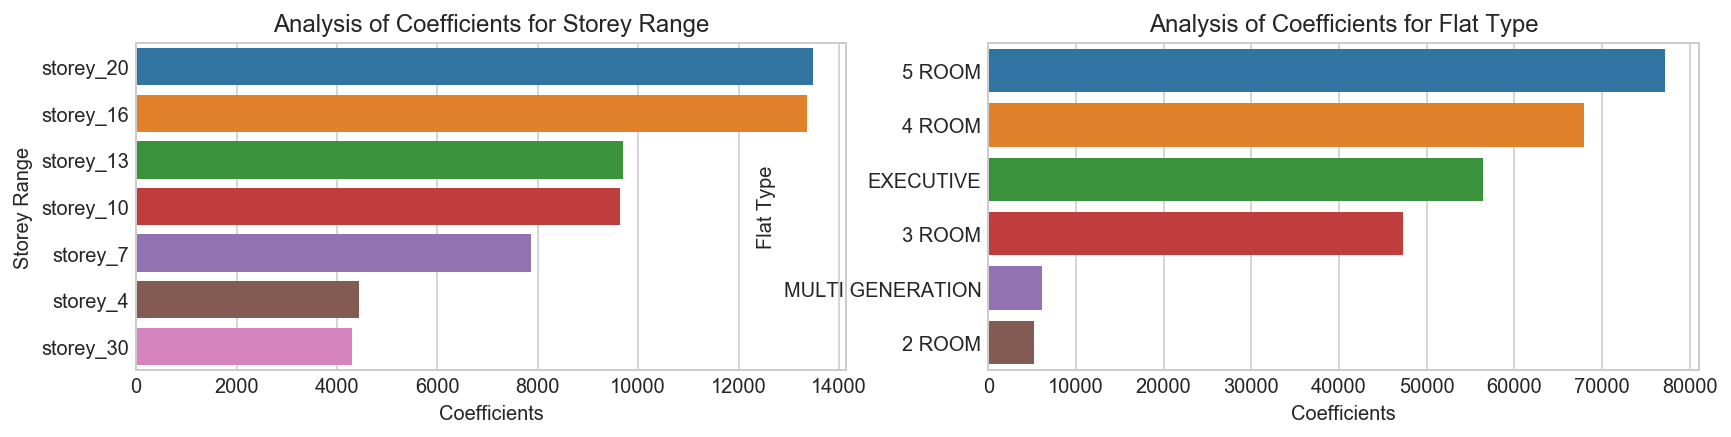

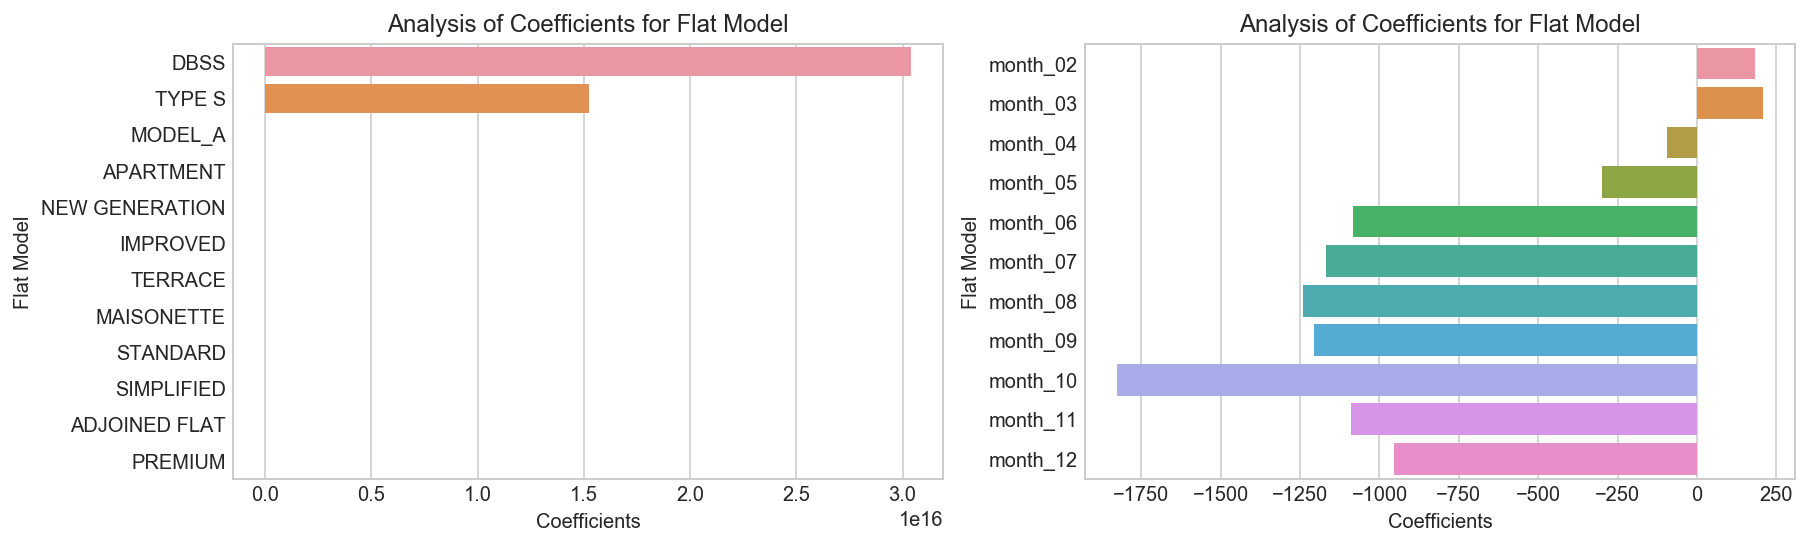

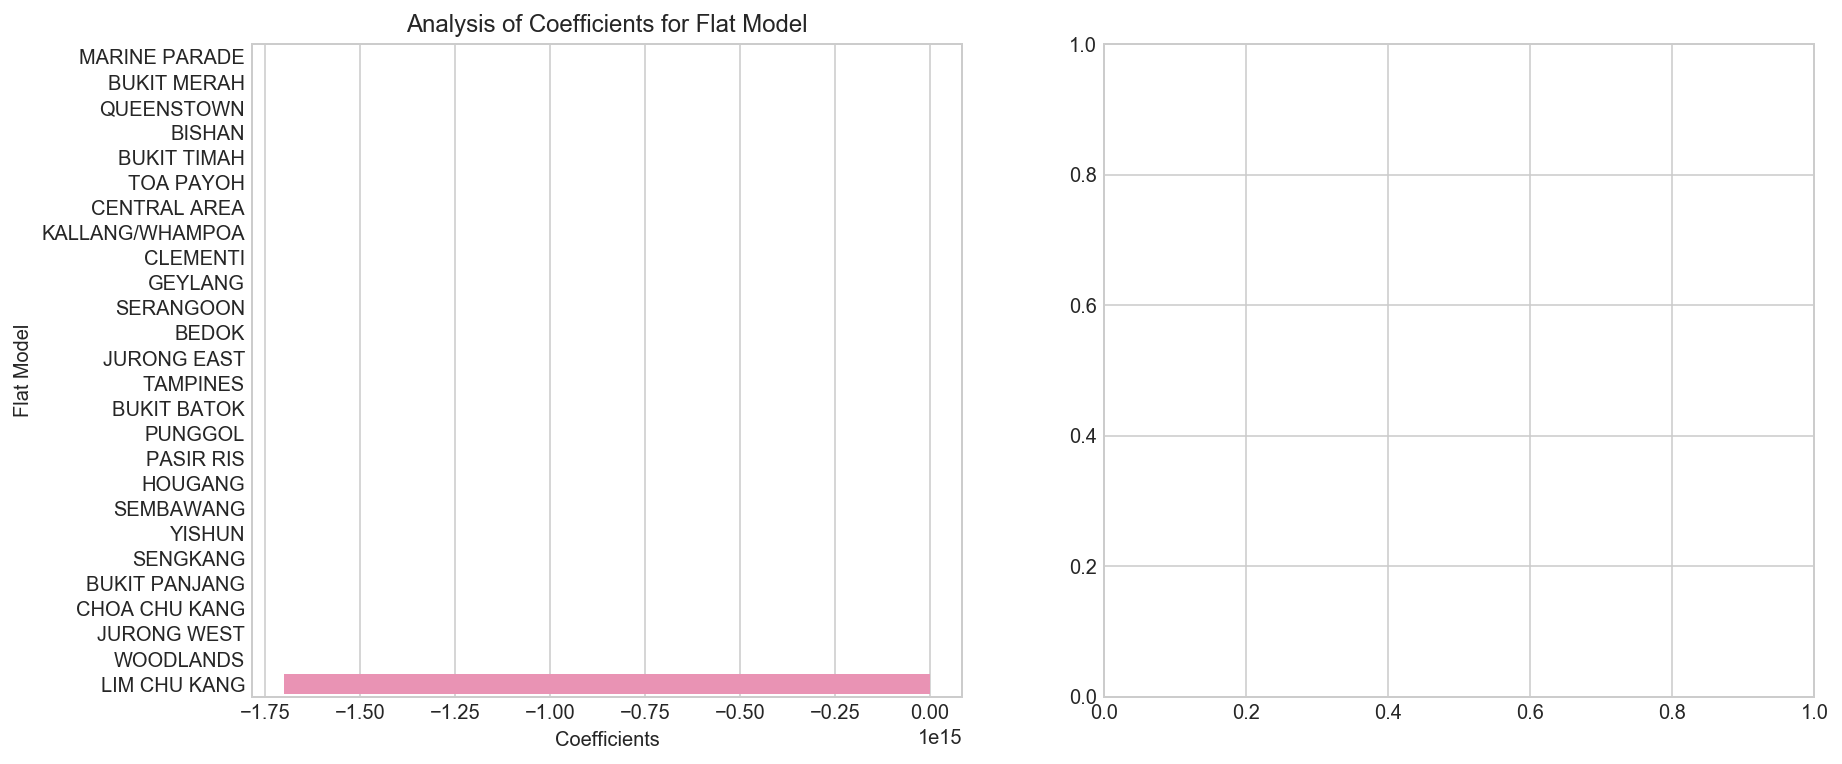

In [44]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter4a_basic linreg',summary_model,[])
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='4aregularization'></a>
#### Iteration 4a: Ridge, Lasso, enet 

Mean of scores: 0.851913662908 | Std of scores: 0.00865497963533
Test score: 0.784981553398
64 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_TYPE S', 'town_LIM CHU KANG']
        abs_coef          coef             variable
15  76812.765162  76812.765162     flat_type_5 ROOM
14  67561.861178  67561.861178     flat_type_4 ROOM
16  56172.095418  56172.095418  flat_type_EXECUTIVE
65  49595.775438  49595.775438       floor_area_sqm
13  46955.600830  46955.600830     flat_type_3 ROOM
60  28575.469566 -28575.469566       town_WOODLANDS
48  26139.177430 -26139.177430     town_JURONG WEST
43  21867.999618 -21867.999618   town_CHOA CHU KANG
66  21469.539281  21469.539281  lease_commence_date
40  19575.772730 -19575.772730   town_BUKIT PANJANG


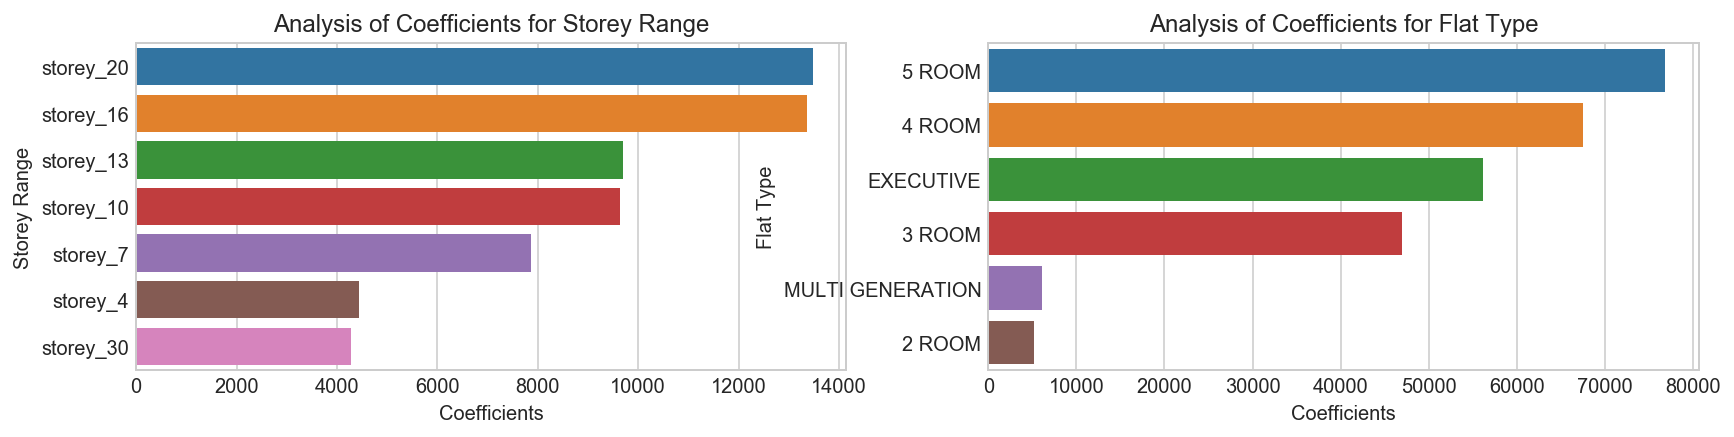

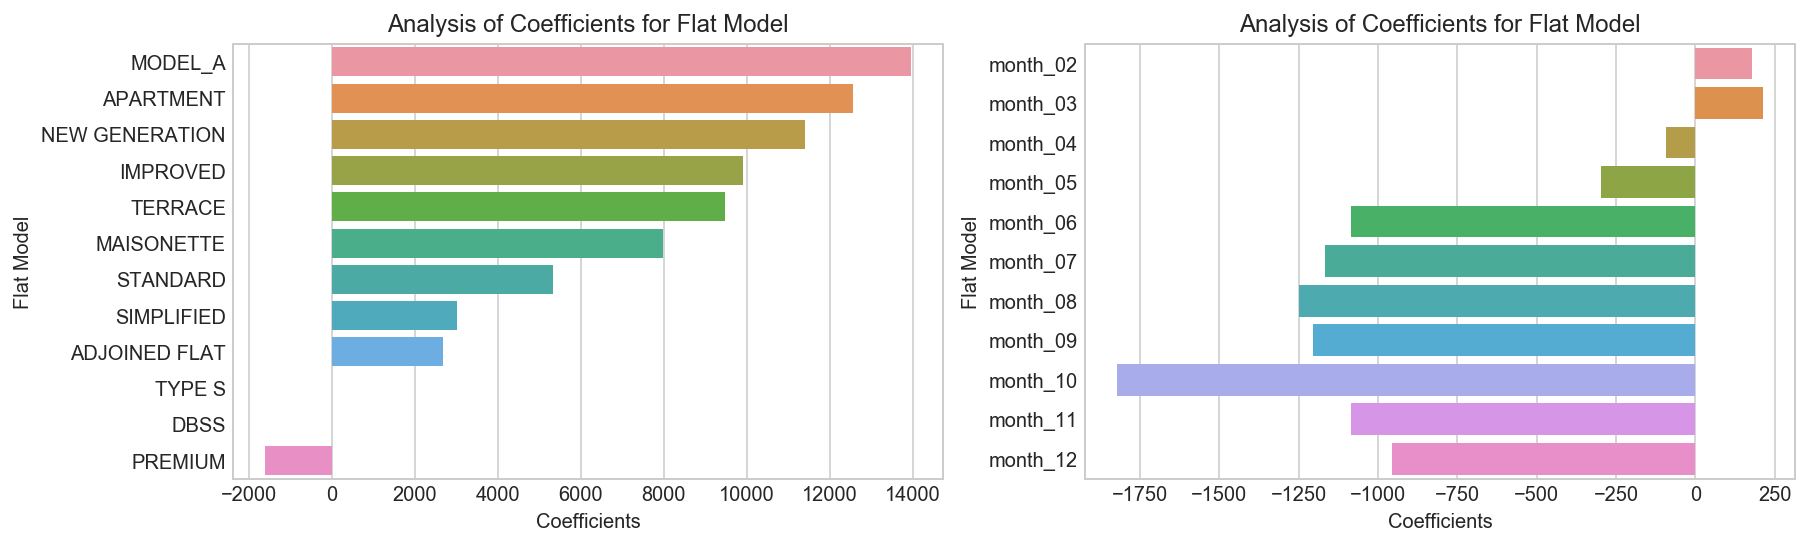

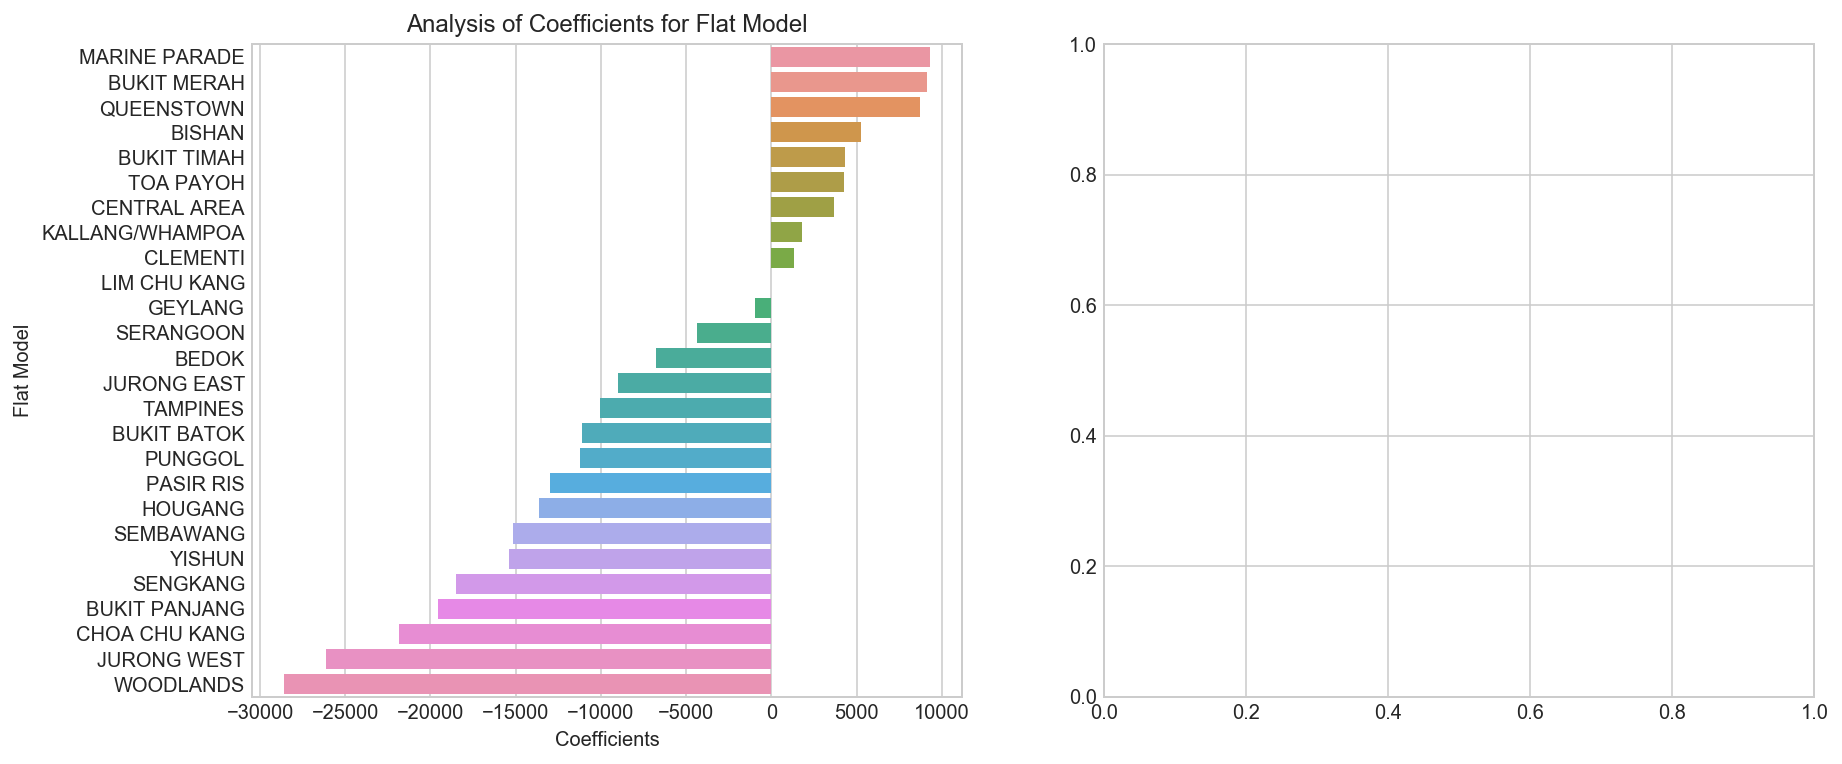

In [45]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter4a_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.851254465661 | Std of scores: 0.00850448131644
Test score: 0.78943644738
60 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'month_str_05', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
65  54549.190915  54549.190915       floor_area_sqm
15  27821.564463  27821.564463     flat_type_5 ROOM
60  26778.129057 -26778.129057       town_WOODLANDS
48  24723.901313 -24723.901313     town_JURONG WEST
16  24058.548919  24058.548919  flat_type_EXECUTIVE
66  21702.682826  21702.682826  lease_commence_date
43  20710.001841 -20710.001841   town_CHOA CHU KANG
40  18465.812545 -18465.812545   town_BUKIT PANJANG
56  17069.719210 -17069.719210        town_SENGKANG
14  14833.693583  14833.693583     flat_type_4 ROOM


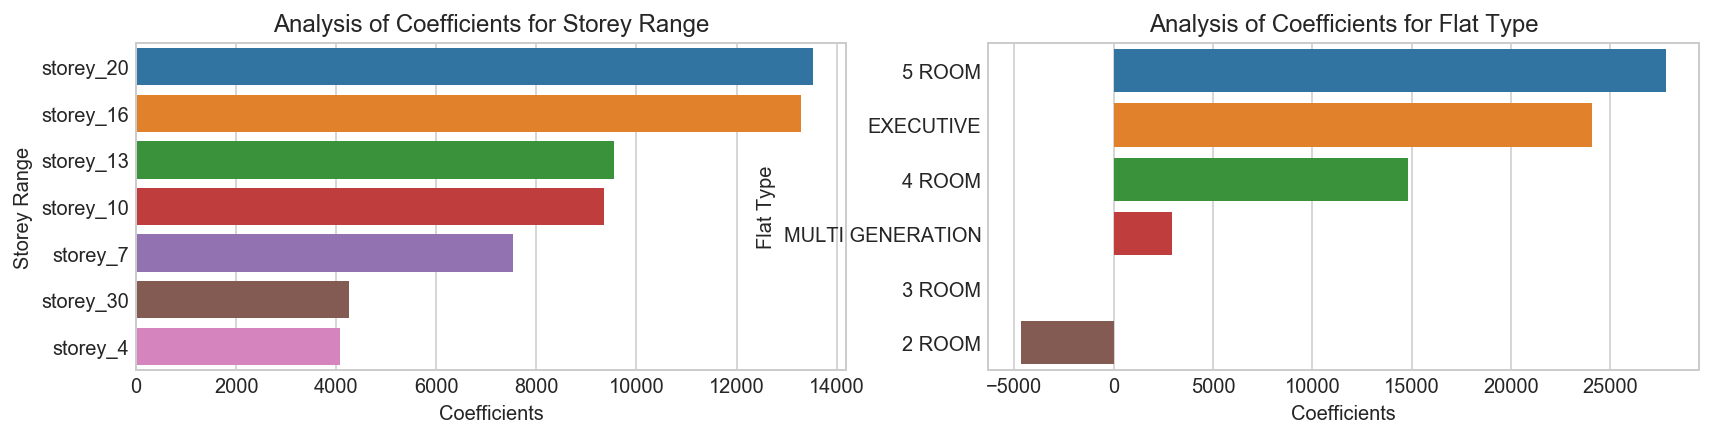

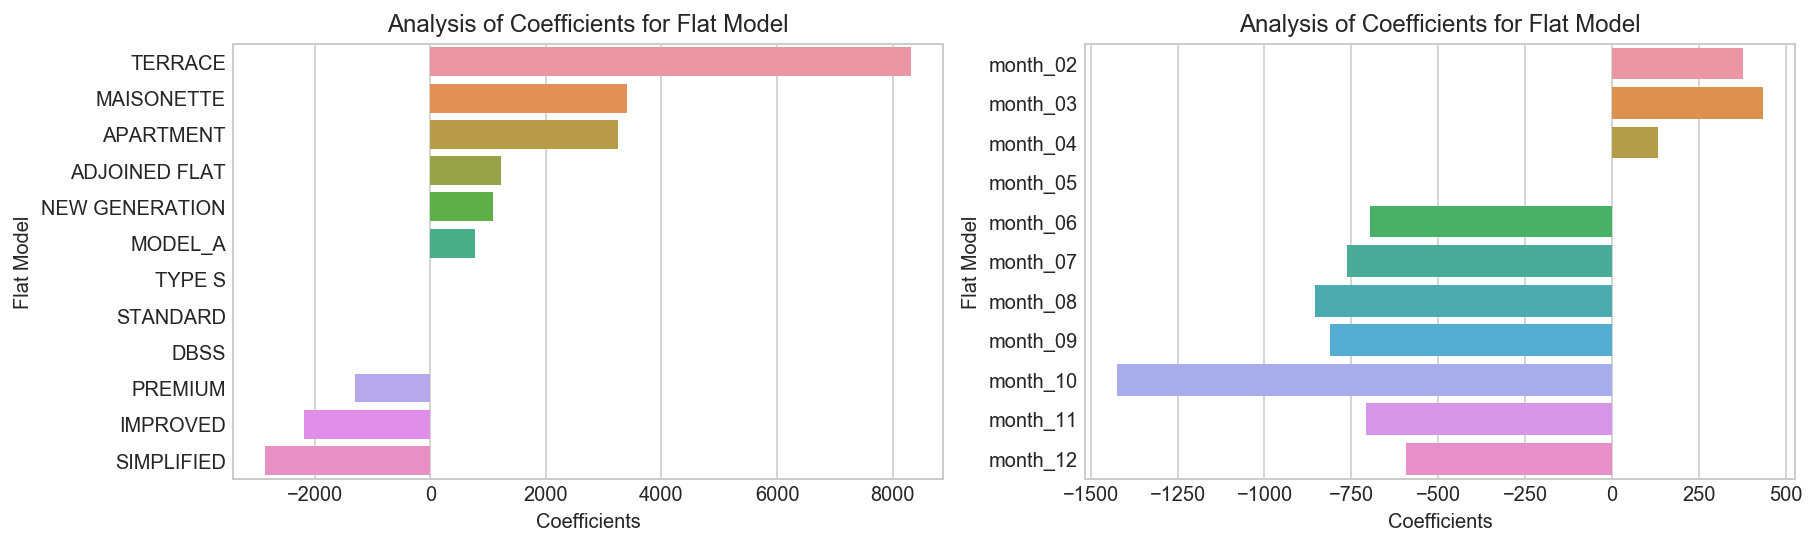

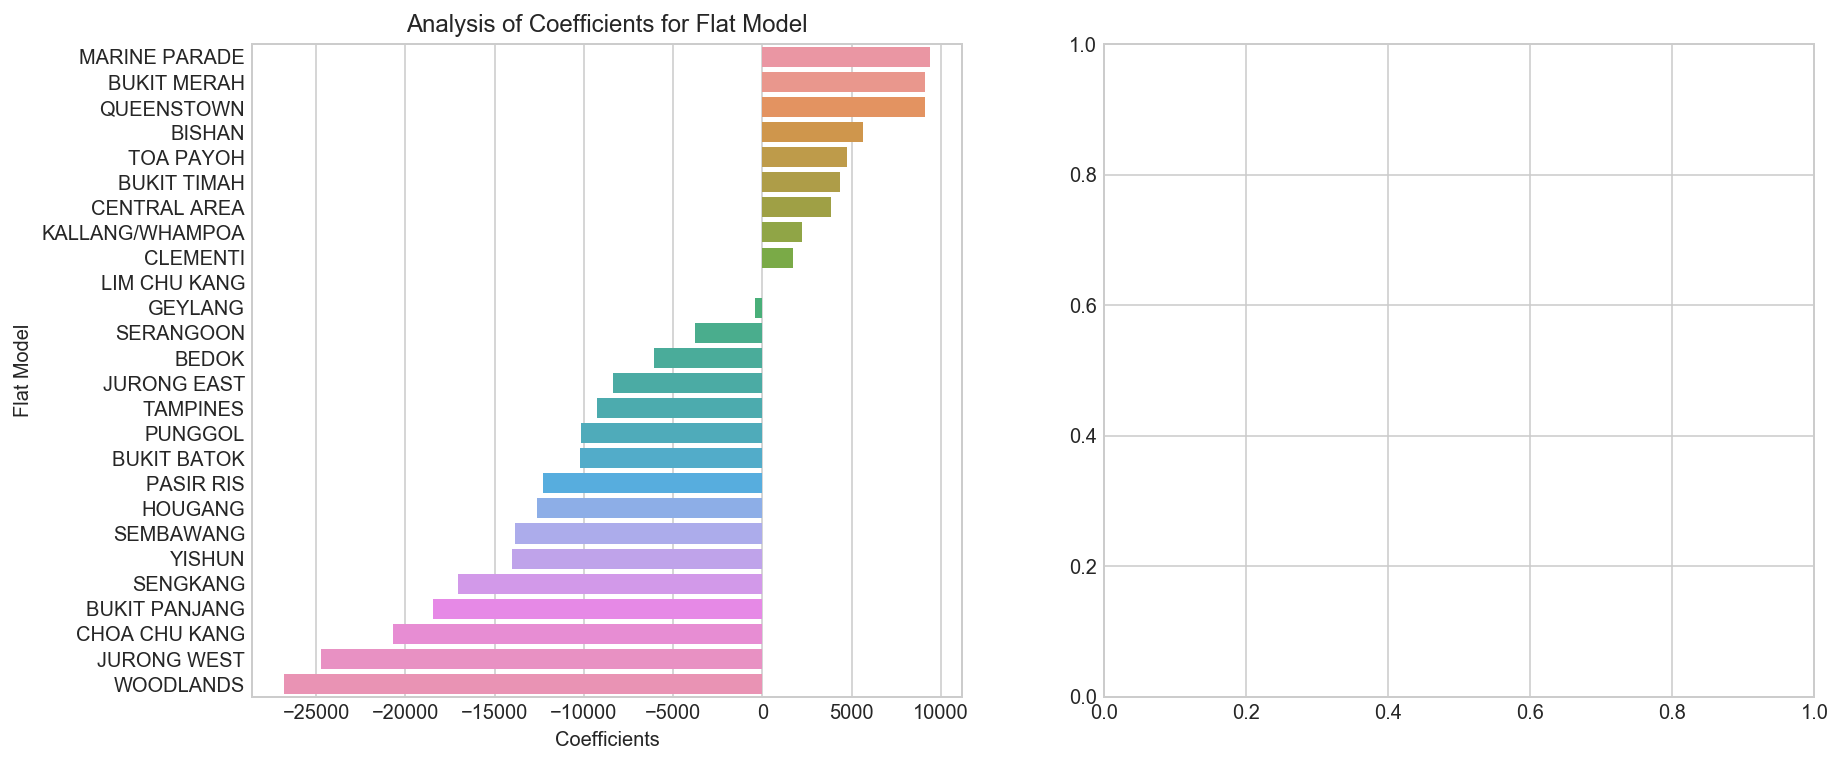

In [46]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter4a_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.851254465661 | Std of scores: 0.00850448131644
Test score: 0.78943644738
60 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'month_str_05', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
65  54549.190915  54549.190915       floor_area_sqm
15  27821.564463  27821.564463     flat_type_5 ROOM
60  26778.129057 -26778.129057       town_WOODLANDS
48  24723.901313 -24723.901313     town_JURONG WEST
16  24058.548919  24058.548919  flat_type_EXECUTIVE
66  21702.682826  21702.682826  lease_commence_date
43  20710.001841 -20710.001841   town_CHOA CHU KANG
40  18465.812545 -18465.812545   town_BUKIT PANJANG
56  17069.719210 -17069.719210        town_SENGKANG
14  14833.693583  14833.693583     flat_type_4 ROOM


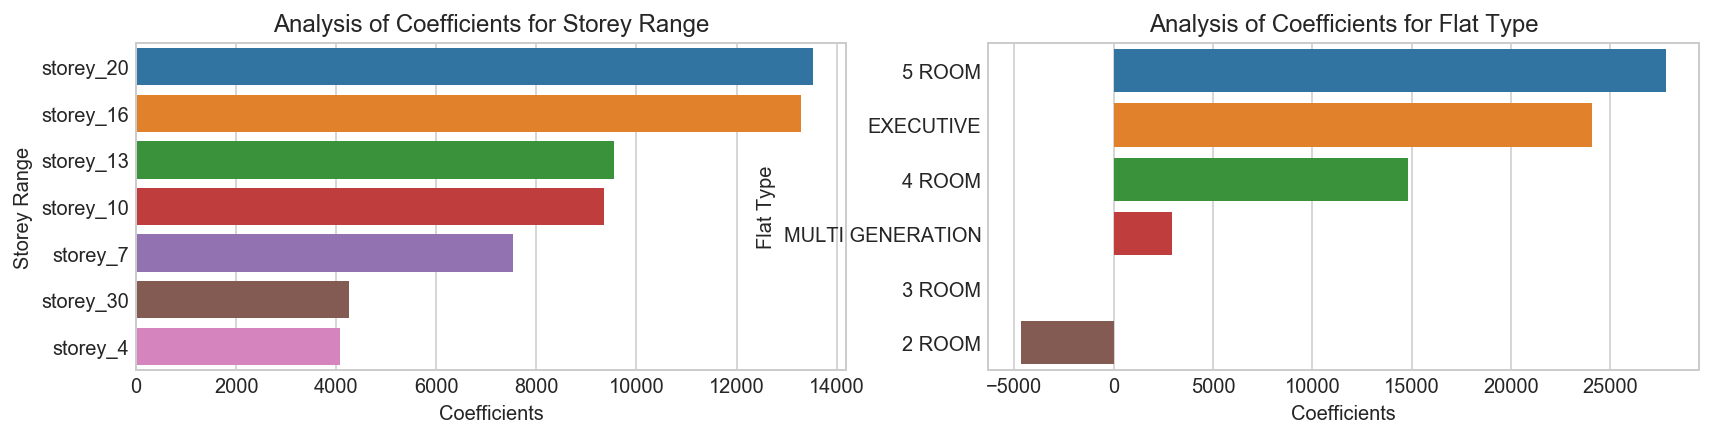

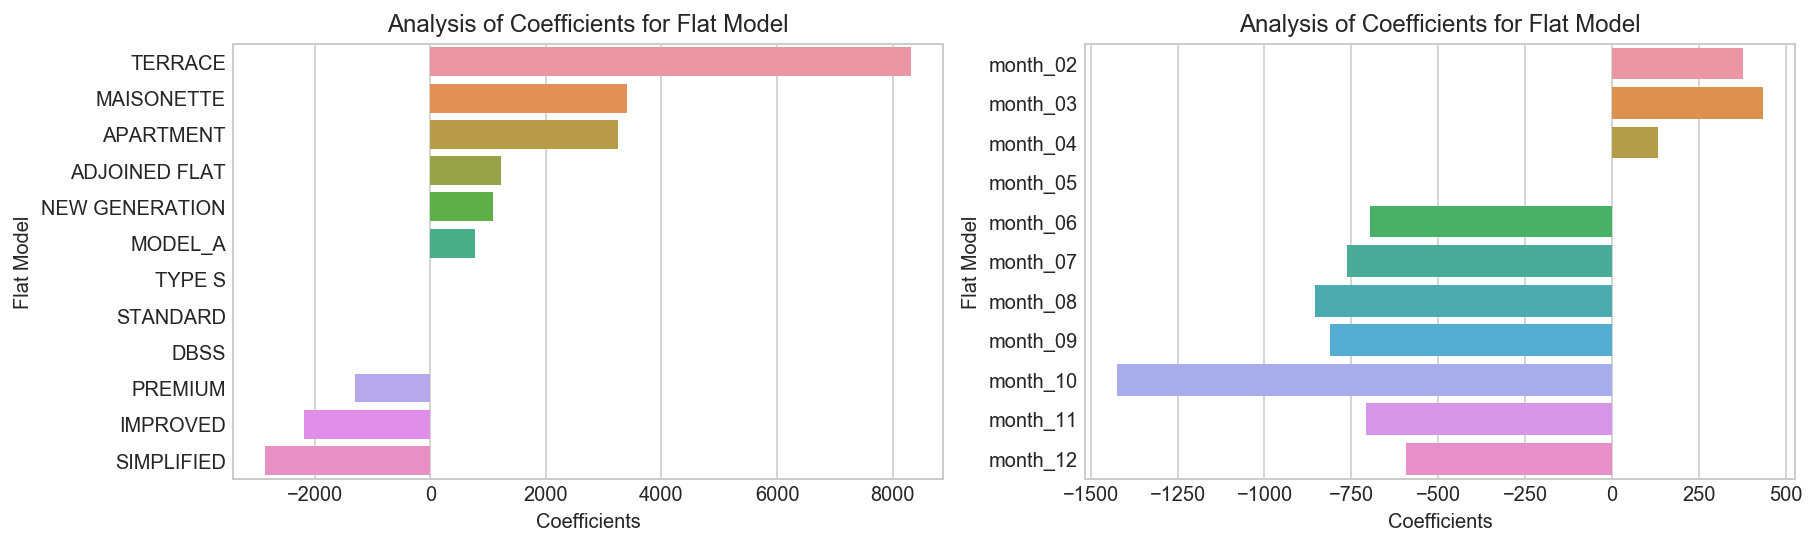

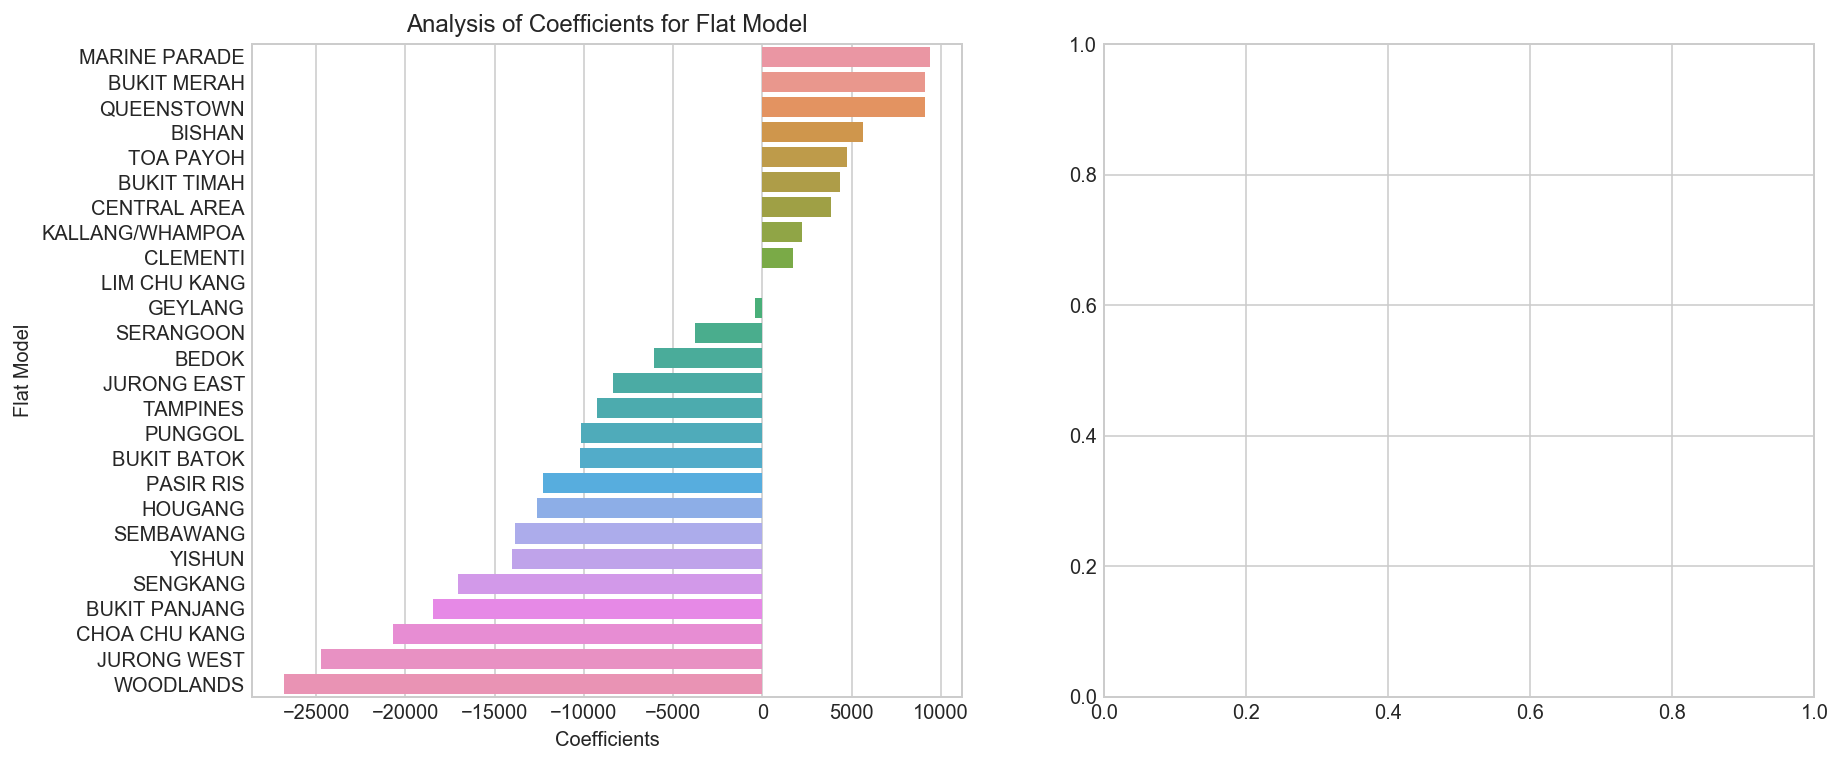

In [47]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter4a_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='iter4b'></a>
### Iteration 4b

In [48]:
df = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col and 'month' not in col]],df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)

train = df[(df['year']<2014)&(df['year']>2004)]
test = df[df['year']>=2014]

X = df.drop(['var_resale_price','var_adj_price','year'],axis=1)
X_train = train.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_train = train['var_adj_price']
X_test = test.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_test = test['var_adj_price']


<a id='4bmlrall'></a>
#### Iteration 4b: Multiple variable Linear regression: ALL 

Mean of scores: 0.852244645618 | Std of scores: 0.00928771005651
Test score: -5.06024908988e+19
56 out of 56 features are selected.
Coefficients not used: []
        abs_coef          coef             variable
5   9.865453e+15 -9.865453e+15      flat_model_DBSS
11  4.457747e+15  4.457747e+15    flat_model_TYPE S
39  1.902162e+10 -1.902162e+10    town_LIM CHU KANG
15  7.693700e+04  7.693700e+04     flat_type_5 ROOM
14  6.780181e+04  6.780181e+04     flat_type_4 ROOM
16  5.622888e+04  5.622888e+04  flat_type_EXECUTIVE
54  4.968800e+04  4.968800e+04       floor_area_sqm
13  4.724050e+04  4.724050e+04     flat_type_3 ROOM
49  2.838950e+04 -2.838950e+04       town_WOODLANDS
37  2.605500e+04 -2.605500e+04     town_JURONG WEST


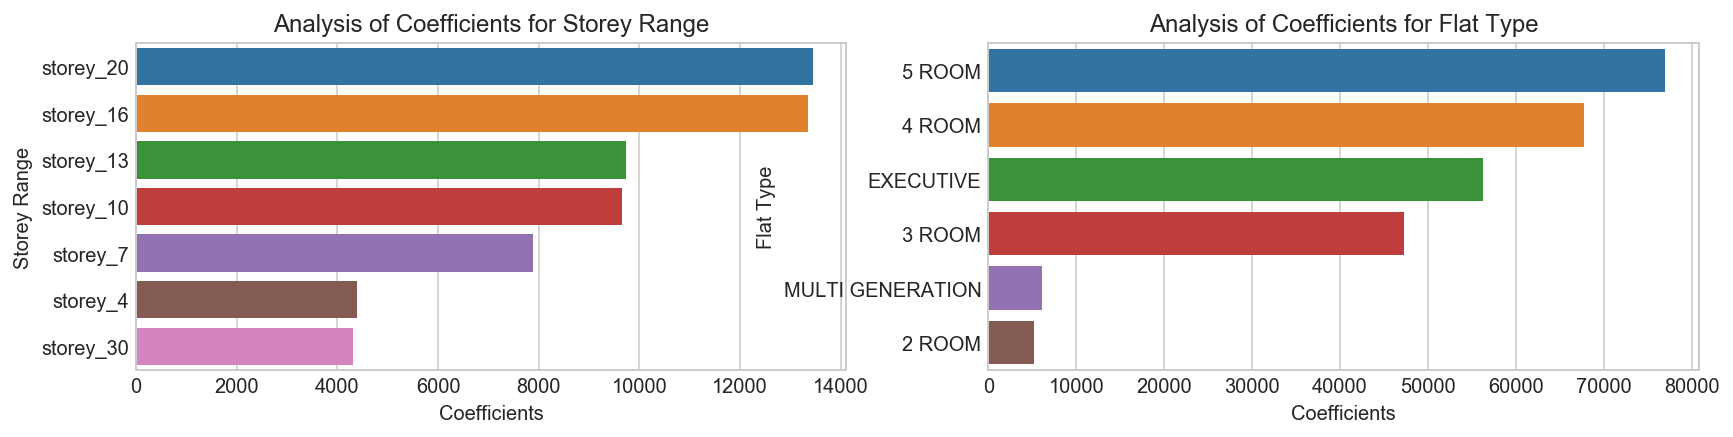

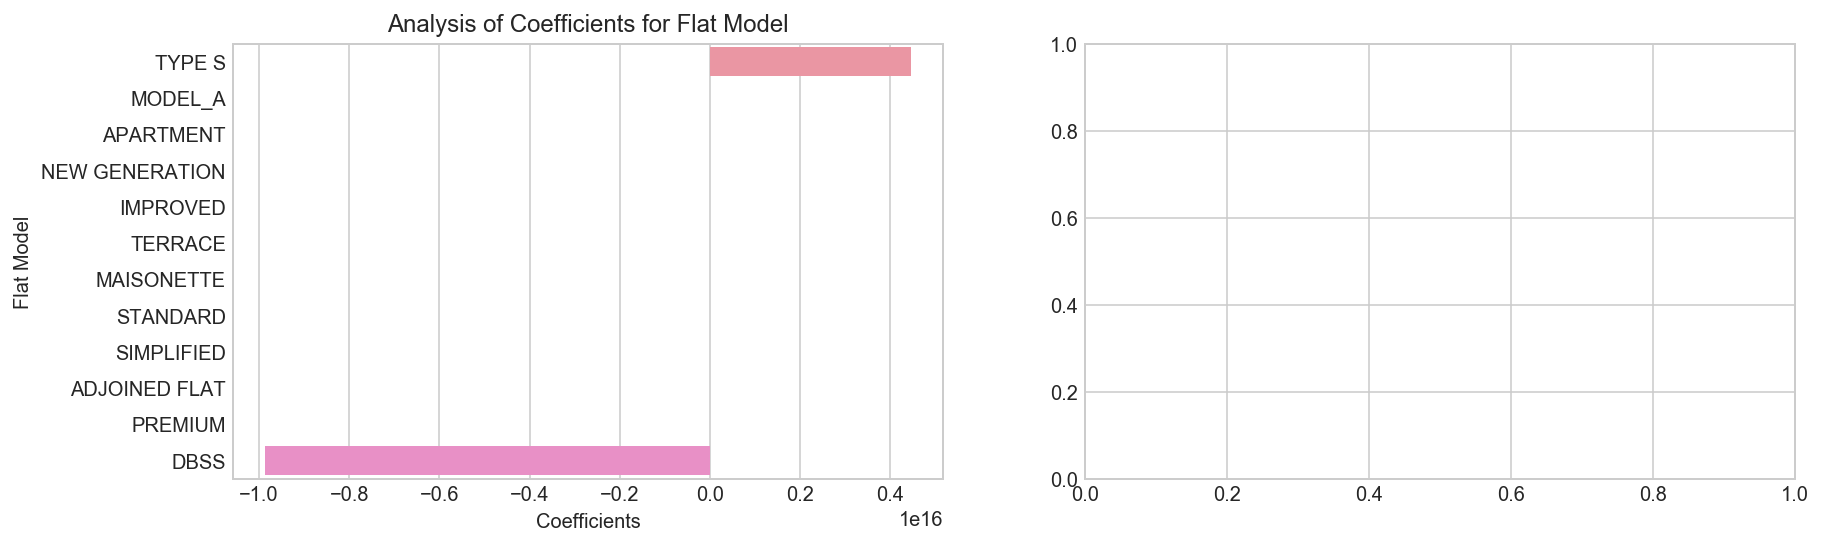

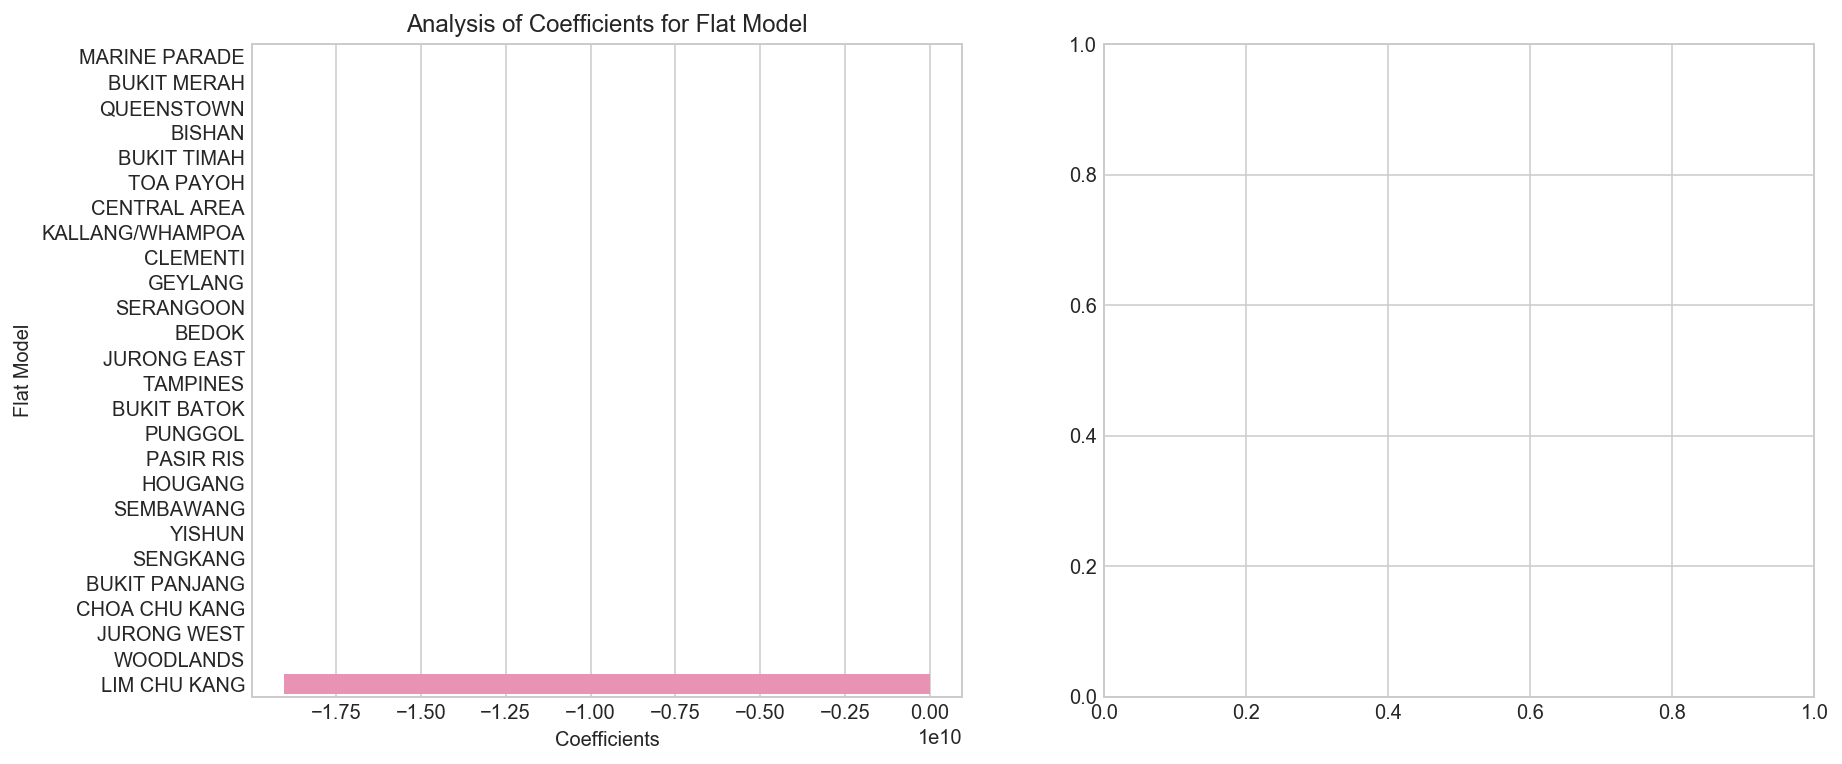

In [49]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter4b_basic linreg',summary_model,summary)
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='4bregularization'></a>
#### Iteration 4b: Ridge, Lasso, enet

Mean of scores: 0.852244176763 | Std of scores: 0.00930848567562
Test score: 0.785278176235
53 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_TYPE S', 'town_LIM CHU KANG']
        abs_coef          coef             variable
15  76672.063976  76672.063976     flat_type_5 ROOM
14  67489.211764  67489.211764     flat_type_4 ROOM
16  56051.511377  56051.511377  flat_type_EXECUTIVE
54  49656.452323  49656.452323       floor_area_sqm
13  46909.533348  46909.533348     flat_type_3 ROOM
49  28518.951140 -28518.951140       town_WOODLANDS
37  26092.465423 -26092.465423     town_JURONG WEST
32  21839.955845 -21839.955845   town_CHOA CHU KANG
55  21517.112083  21517.112083  lease_commence_date
29  19563.094657 -19563.094657   town_BUKIT PANJANG


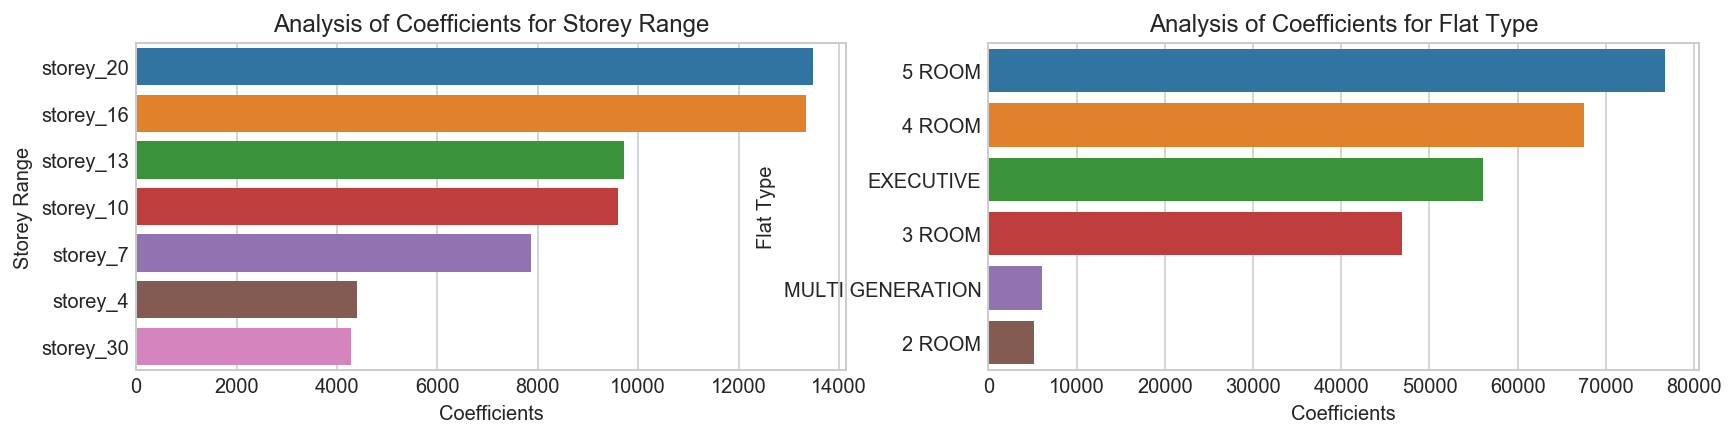

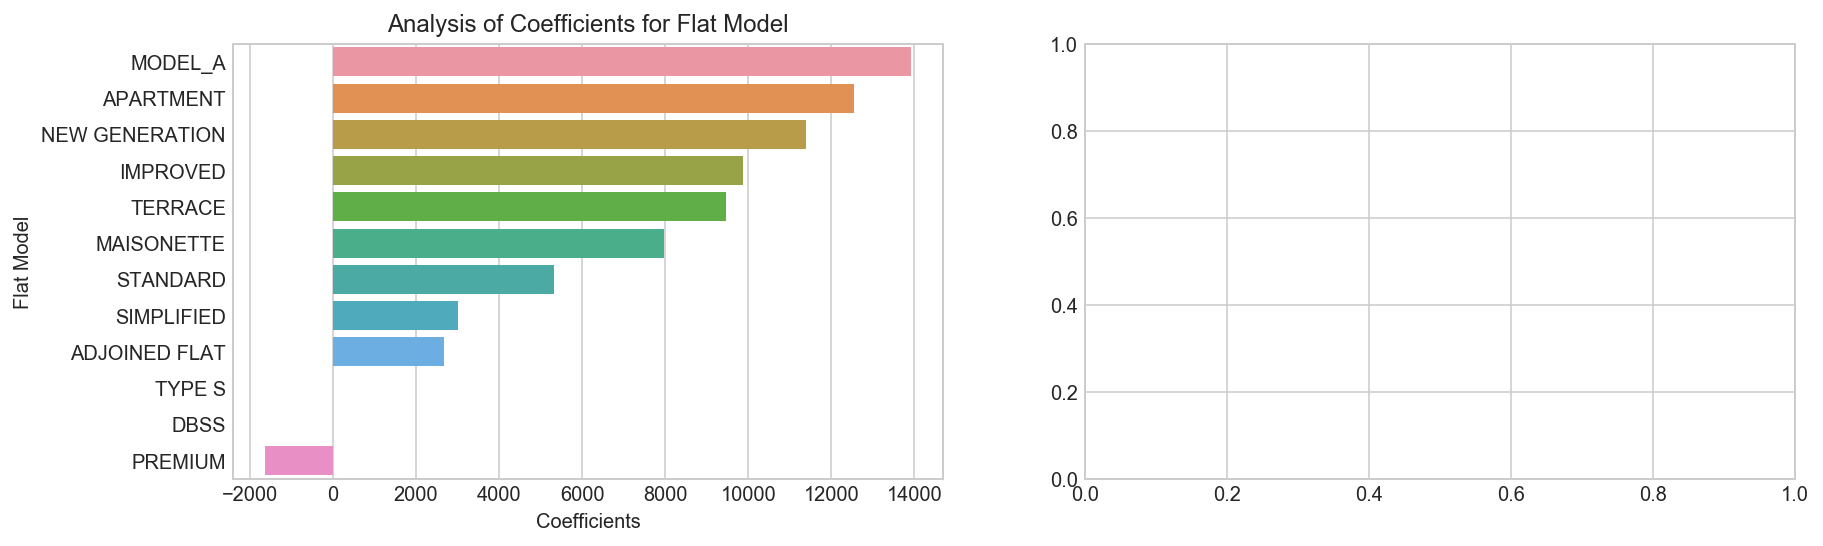

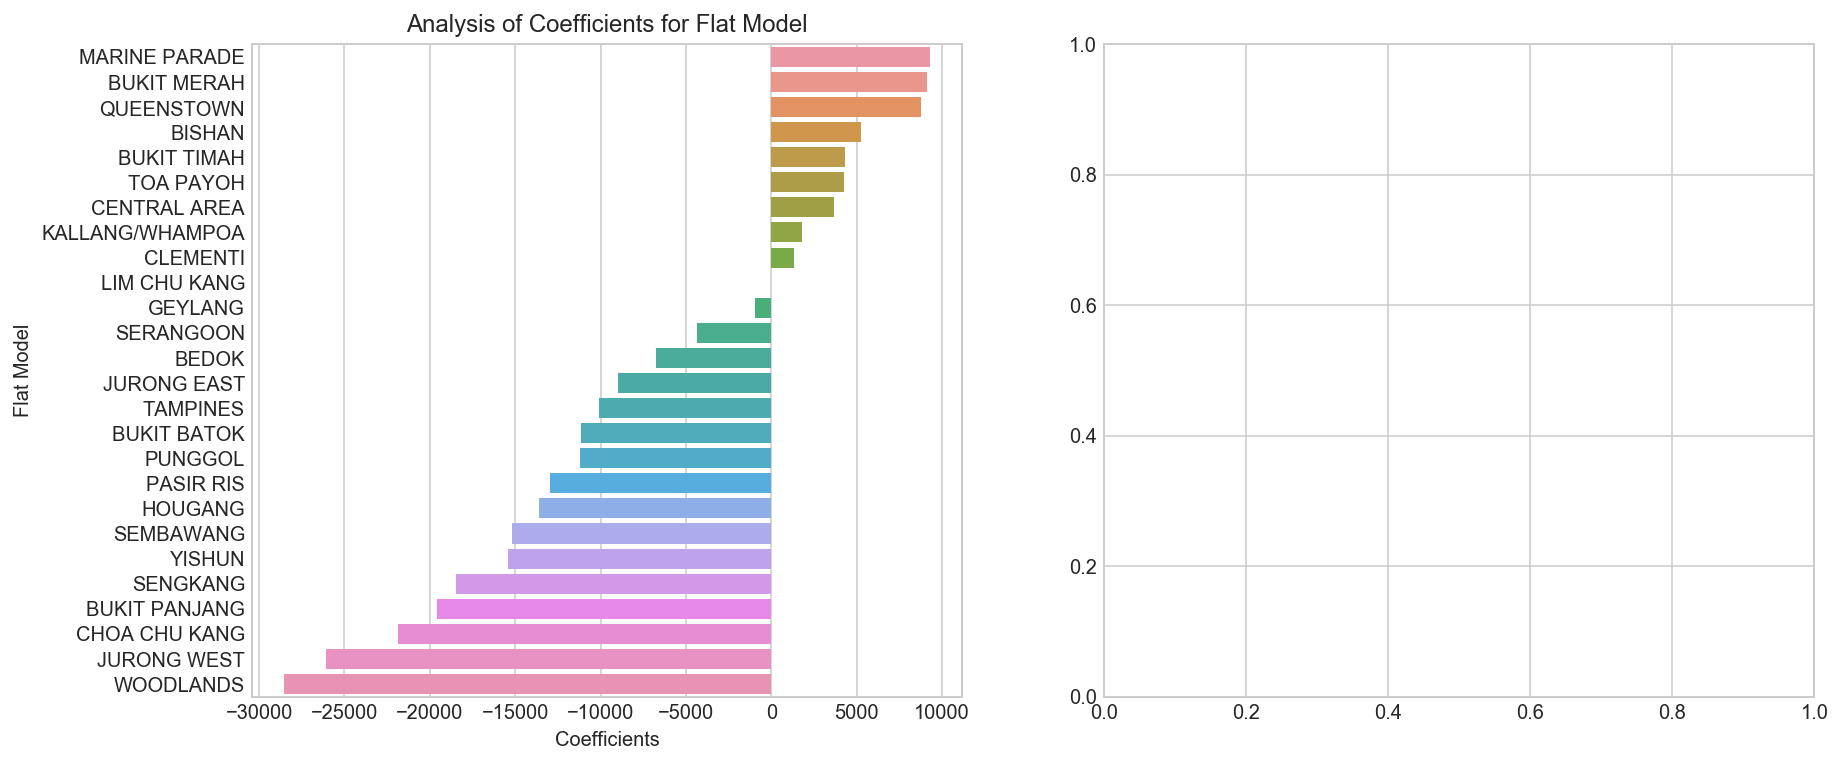

In [50]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter4b_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.851502482585 | Std of scores: 0.00909022978493
Test score: 0.789695067369
50 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
54  54603.916053  54603.916053       floor_area_sqm
15  27734.532467  27734.532467     flat_type_5 ROOM
49  26737.623021 -26737.623021       town_WOODLANDS
37  24699.463708 -24699.463708     town_JURONG WEST
16  23977.317879  23977.317879  flat_type_EXECUTIVE
55  21743.409870  21743.409870  lease_commence_date
32  20694.927379 -20694.927379   town_CHOA CHU KANG
29  18460.737089 -18460.737089   town_BUKIT PANJANG
45  17065.034628 -17065.034628        town_SENGKANG
14  14813.431454  14813.431454     flat_type_4 ROOM


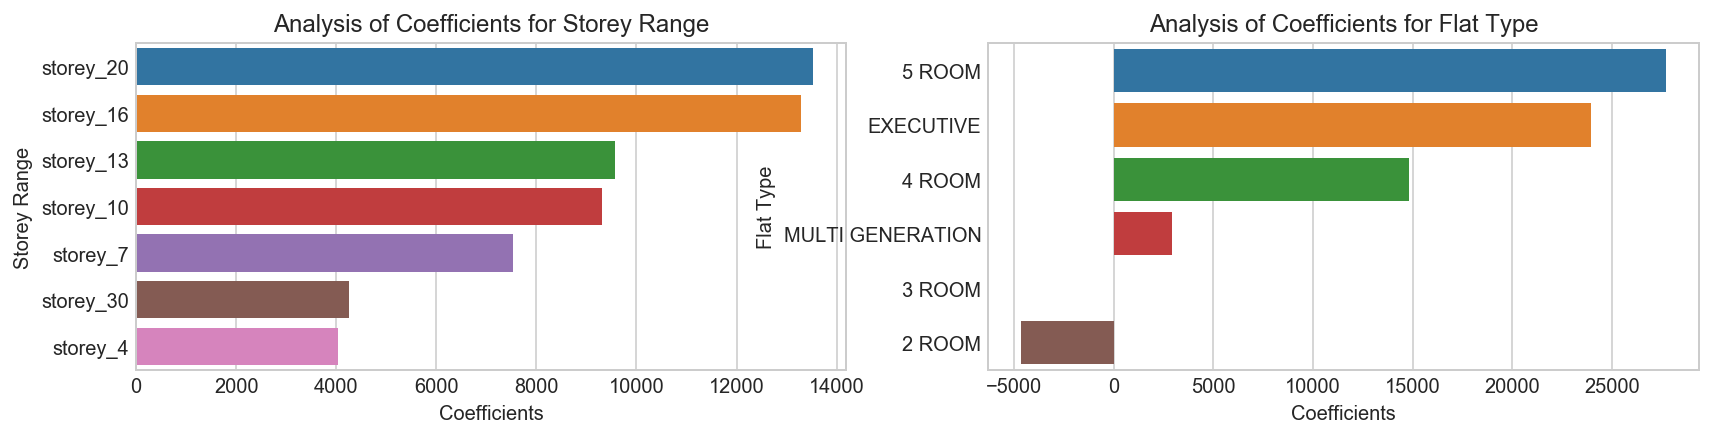

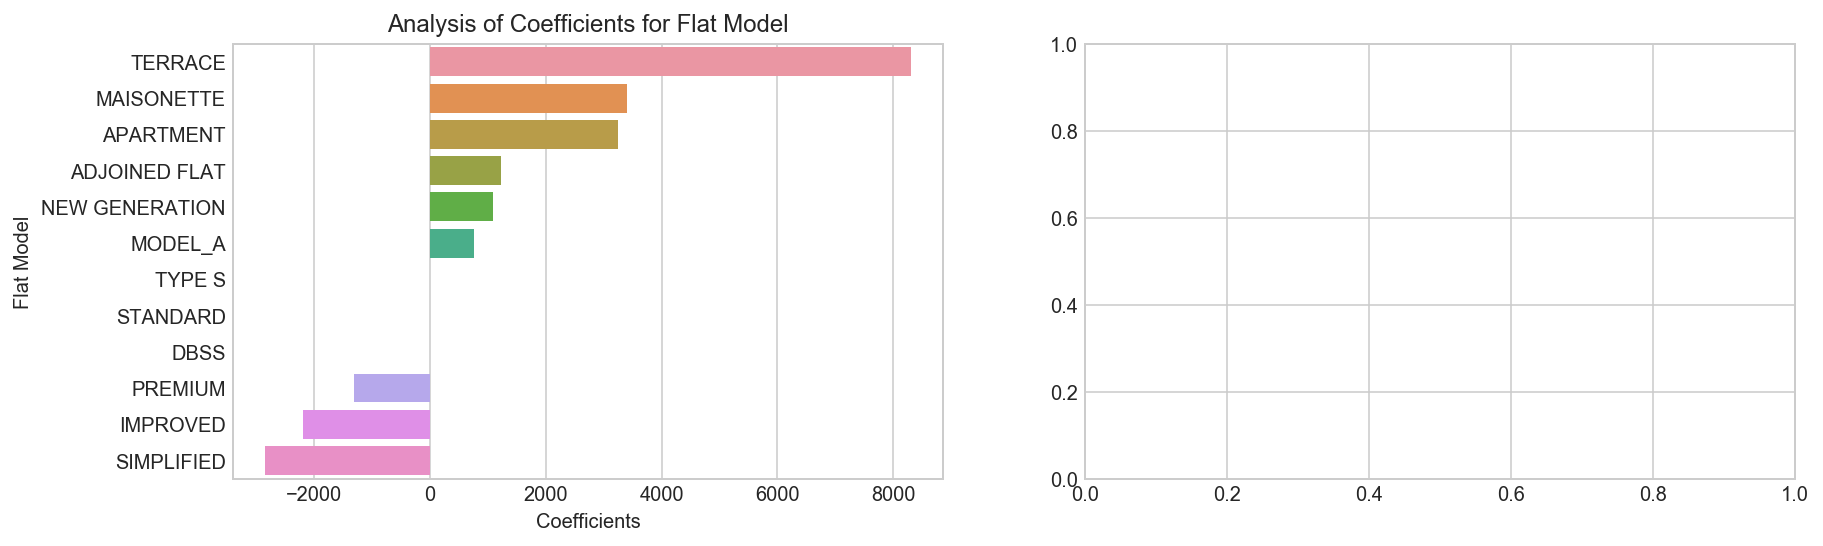

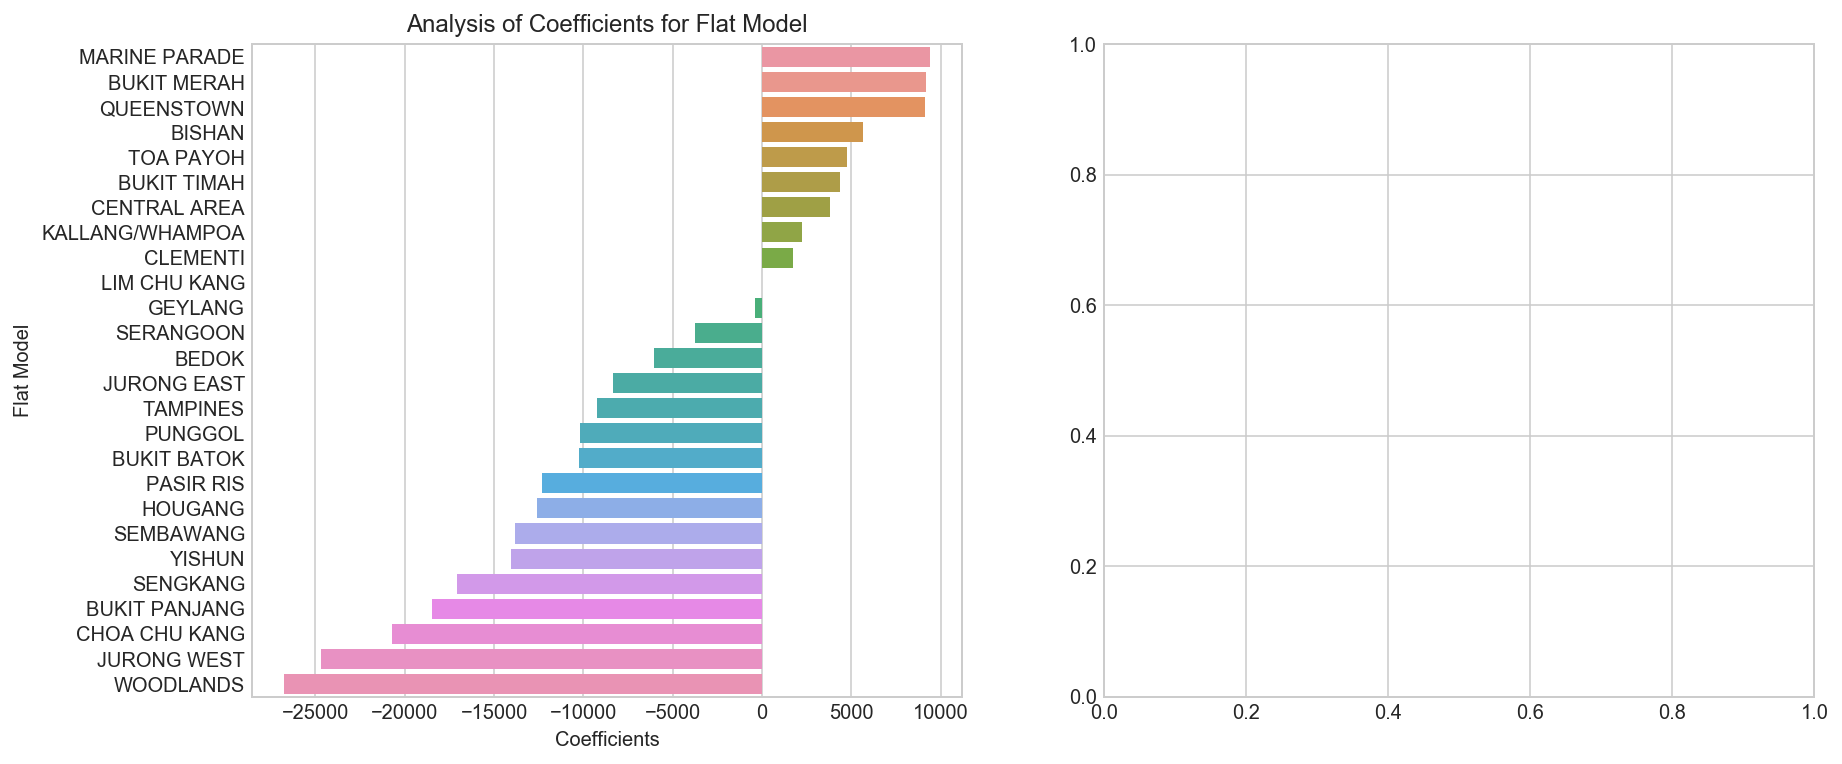

In [51]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.851502482585 | Std of scores: 0.00909022978493
Test score: 0.789695067369
50 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_STANDARD', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'town_LIM CHU KANG', 'longitude']
        abs_coef          coef             variable
54  54603.916053  54603.916053       floor_area_sqm
15  27734.532467  27734.532467     flat_type_5 ROOM
49  26737.623021 -26737.623021       town_WOODLANDS
37  24699.463708 -24699.463708     town_JURONG WEST
16  23977.317879  23977.317879  flat_type_EXECUTIVE
55  21743.409870  21743.409870  lease_commence_date
32  20694.927379 -20694.927379   town_CHOA CHU KANG
29  18460.737089 -18460.737089   town_BUKIT PANJANG
45  17065.034628 -17065.034628        town_SENGKANG
14  14813.431454  14813.431454     flat_type_4 ROOM


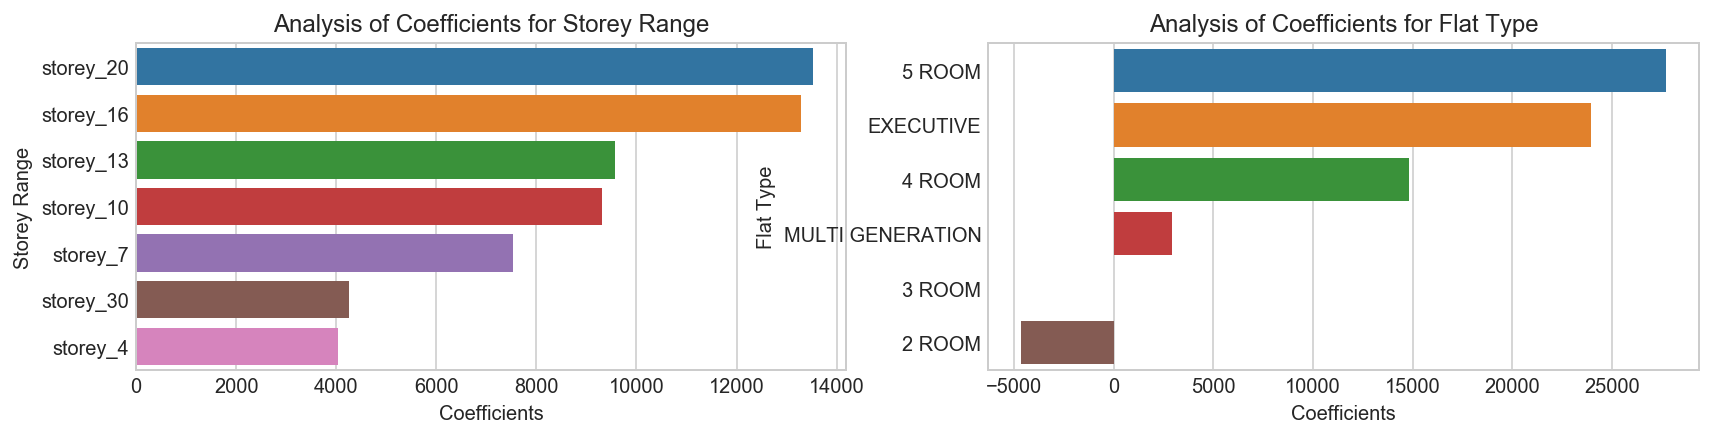

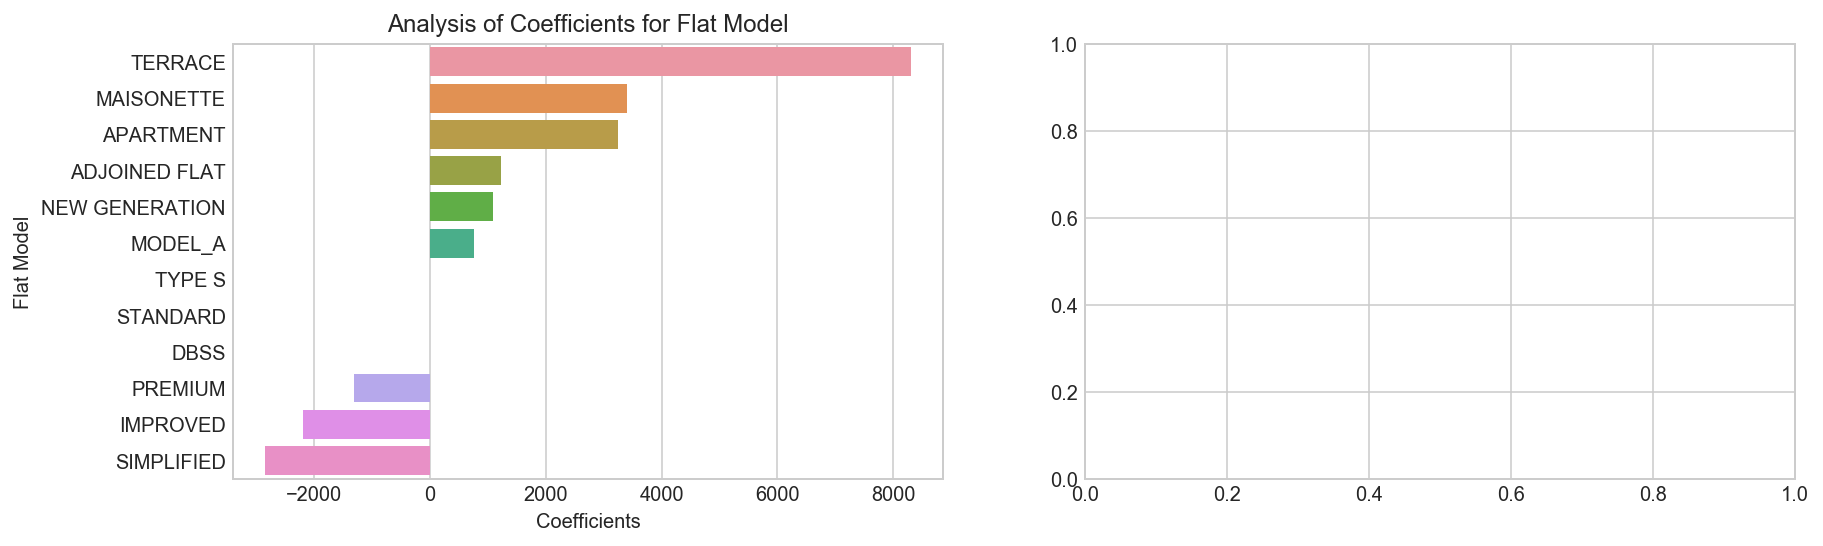

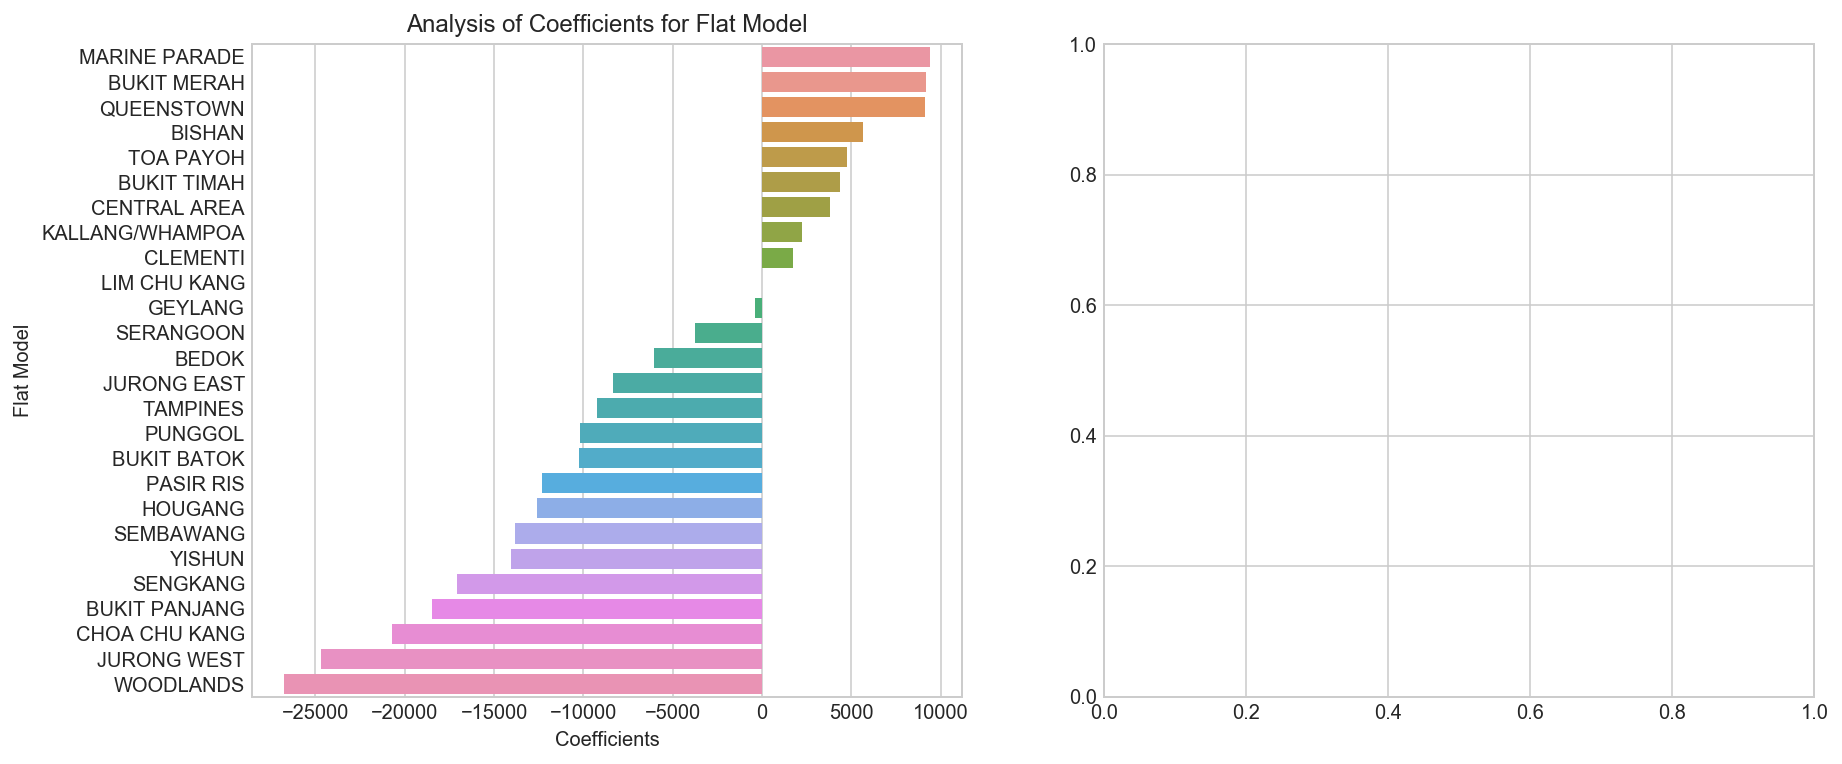

In [52]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

## Insights

In [53]:
summary.sort_values('test_score',ascending = False)

,model,train_mean_score,train_std_score,test_score
0,iter3b_basic lasso,0.851502,0.00909023,0.789695
0,iter3b_basic enet,0.851502,0.00909023,0.789695
0,iter4a_basic lasso,0.851254,0.00850448,0.789436
0,iter4a_basic enet,0.851254,0.00850448,0.789436
0,iter4b_basic ridge,0.852244,0.00930849,0.785278
0,iter4a_basic ridge,0.851914,0.00865498,0.784982
0,iter4b_basic linreg,0.852245,0.00928771,-5.06025e+19
0,iter4a_basic linreg,0.851915,0.00865026,-4.88631e+20


Iter3a: (all X variables except year variables)           + (y = var resale price)<br>
Iter3b: (all X variables except year and month variables) + (y = var resale price)<br>
Iter4a: (all X variables except year variables)           + (y = var adj price)<br>
Iter4b: (all X variables except year and month variables) + (y = var adj price)<br>

From the `summary` above, we have the following insights: 
- Immediately the score makes sense as time is not taken into consideration but the score is equally good using a time series train-test-split method 
-



